In [1]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import pickle
import lasio  # las files 
import numpy as np
from scipy.interpolate import interp1d

In [2]:
log=lasio.read(r'F:\Poseidon\Python Poseidon\Crossplot sensitive of Overpressure\New Data\Well\Poseidon North 1_logs.las')
log=log.df().reset_index()
log.head()

,DEPTH,CALI,CHKS,RHOB,GR,UNKNOWN:1,UNKNOWN:2,NPHI,DT:1,DT:2,RES,ILD,SDT
0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67049.3906,NaN,NaN,NaN
1,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3047.6997,NaN,NaN,NaN
2,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1523.8000,NaN,NaN,NaN
3,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1523.7500,NaN,NaN,NaN
4,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1523.7494,NaN,NaN,NaN


#### Calculate Hydrostatic Pressure

In [3]:
d_seawater= 1.024
g=9.81
Mudline = 486 # Seafloor: This an assumed value showing first recorded data points in the well logs.
# Pressure at the Seafloor
P_mudline = d_seawater * g * Mudline*1000
P_mudline

4882083.84

In [4]:
kb=-22
wd=486
depthshift = log[(log.DEPTH >= wd)] - kb - wd
log['DEPTHSHIFT']= depthshift.DEPTH

In [5]:
#To get a hydrostatic profile, we will need to provide a function for all depths
def hydrostatic_pressure_from_TVD(TVDs, d_seawater=d_seawater, p0=P_mudline, g=g):
    """
    Compute hydrostatic pressure from TVD
    z : TVD in m
    return P in Pa
    Note that the water density taken here is seawater density (1.028)
    """
    return p0+ d_seawater*g*1000*TVDs #Pa

In [6]:
log['Hydrostatic_Pressure_at_bit']=hydrostatic_pressure_from_TVD(TVDs=log['DEPTHSHIFT'])
log['Hydrostatic_Pressure_Gradient']=d_seawater*g*1000  # in Pa / m

In [7]:
log['Hydrostatic_Pressure_at_bit2']= d_seawater*g*1000*log['DEPTH']

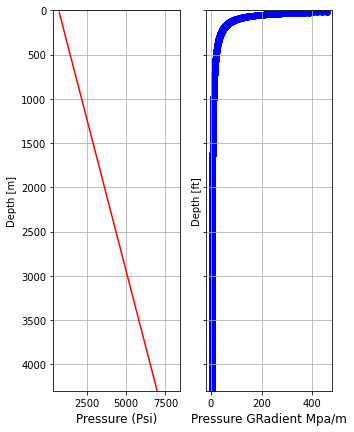

In [8]:
fig,axs=plt.subplots(1,2,figsize=(5,7),sharey=True)
ax=axs[0]
ax.plot(log['Hydrostatic_Pressure_at_bit']*(145.038/1e6),log['DEPTHSHIFT'],linestyle='-', c='r',label='Pressure')
ax.set_xlabel('Pressure (Psi)',fontsize='large')
ax.set_ylabel('Depth [m]')
ax.grid()
ax=axs[1]
ax.scatter(log['Hydrostatic_Pressure_Gradient']/log.DEPTH,log['DEPTH'], c='b',label='Pressure/m')
ax.set_xlabel('Pressure GRadient Mpa/m',fontsize='large')
ax.set_ylabel('Depth [ft]')
ax.grid()
ax.set_ylim(0,4300)
ax.invert_yaxis()

In [9]:
import pandas as pd
df = pd.read_csv(r'F:\Poseidon\Python Poseidon\Pressure Data\excel\excel\POSEIDON NORTH1.csv', delimiter=';')
print(df)

     No.       date   MDRT (m)  TVDRT (m)  Pore Pressure (ppg)  \
0    1.0  20/03/2014    568.34     568.34                  8.4   
1    2.0  21/03/2014   1321.00    1321.00                  8.5   
2    3.0  22/03/2014   1427.00    1426.90                  8.5   
3    4.0  23/03/2014   1918.00    1917.80                  8.5   
4    5.0  24/03/2014   2190.00    2189.70                  8.5   
..   ...         ...       ...        ...                  ...   
994  NaN         NaN       NaN        NaN                  NaN   
995  NaN         NaN       NaN        NaN                  NaN   
996  NaN         NaN       NaN        NaN                  NaN   
997  NaN         NaN       NaN        NaN                  NaN   
998  NaN         NaN       NaN        NaN                  NaN   

     Mud Weight (ppg)  LOT (ppg)   MDRT (m).1  TVDRT (m).1  Pore (psi/ft)  \
0                 8.7        NaN  1864.632606  1864.632606         0.4368   
1                 8.6        NaN  4333.989640  4333.9

In [10]:
df1=df
df2=df
df1=df1[df1['LOT (psi) TVD'] != 0]
df2=df2.dropna(subset = ['Mud Weight(psi) TVD'])
df2=df2[df2['Mud Weight(psi) TVD'] != 0]
# df1.drop(index=str("#VALUE!"), columns='LOT (Psi)')
depthshiftlot=df1['TVDRT (m)']-kb-wd
depthshiftmud=df2['TVDRT (m)']-kb-wd

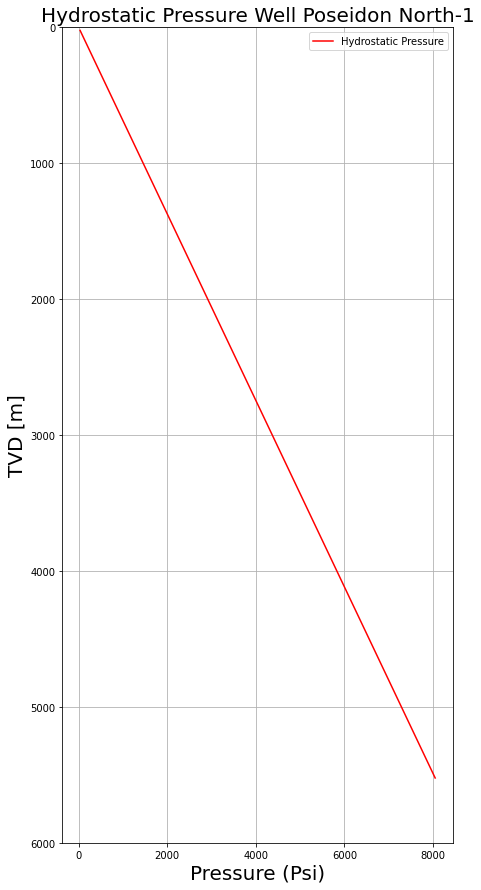

In [11]:
fig,ax=plt.subplots(figsize=(7,15))
ax.set_title("Hydrostatic Pressure Well Poseidon North-1",fontsize=20)
ax.plot(log['Hydrostatic_Pressure_at_bit2']*(145.038/1e6),log['DEPTH'],linestyle='-', c='r',label='Hydrostatic Pressure')
ax.set_xlabel('Pressure (Psi)',fontsize=20)
ax.set_ylabel('TVD [m]',fontsize=20)
# reset the plot configurations to default
plt.rcdefaults()
# change the fontsize of the xtick and ytick labels
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
ax.set_ylim(0,6000)
ax.grid()
ax.legend()
ax.invert_yaxis()

# Calculate Overburden Pressure From Log RHOB 

In [12]:
def med_filt(window=4000):
    min_per = 1 # to avoid getting NaN if there is a single NaN, I request to have at least min_per real numbers in the window
    log[f'RHOB_{window}']= log['RHOB'].rolling(window,min_periods=min_per, center=True).median()
med_filt(300)
med_filt(100)

Text(0.5, 0, 'g/cc')

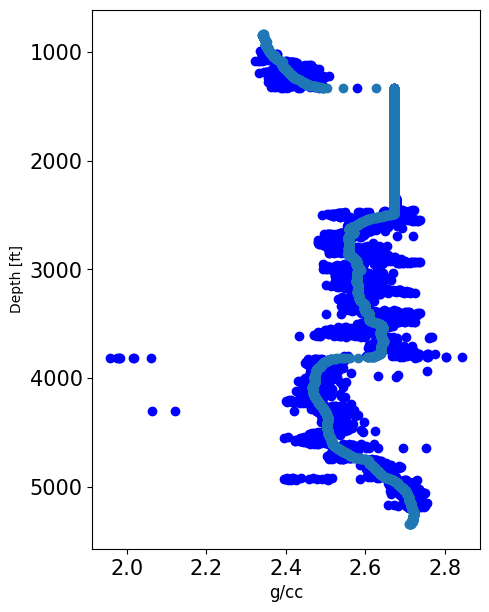

In [13]:
fig,ax=plt.subplots(figsize=(5,7))
ax.scatter(log['RHOB'],log['DEPTH'], c='b',label='Density')
ax.scatter(log.RHOB_300,log.DEPTH)
ax.set_xlabel('Density',fontsize='large')
ax.set_ylabel('Depth [ft]')
# ax.set_ylim(0,5300)
ax.invert_yaxis()
ax.set_xlabel('g/cc')

In [14]:
from scipy.optimize import curve_fit
def traugott(z, a, b):
    r"""
    estimate density with depth

    Parameters
    ----------
    depth : 1-d ndarray
    a, b: scalar

    Notes
    -----
    .. math:: \overline{\rho (h)}=16.3+{h/3125}^{0.6}

    gives the average sediment density in pounds per gallon (ppg) mud weight
    equivalent between the sea floor and depth h (in feet) below the sea floor.

    So, density variation with depth takes the form [2]_:

    .. math:: \rho(z) = {\rho}_{0} + a{z}^{b}

    .. [2] Traugott, Martin. "Pore/fracture pressure determinations in deep
       water." World Oil 218.8 (1997): 68-70.
    """
    # rho0 = 2.65
    return 2.2 + a * z**b

In [15]:
def traugott_trend(depth, a, b, kb=0, wd=0):
    depth_shift = np.array(depth) - kb - wd
    density = traugott(depth_shift, a, b)
    mask = depth_shift < 0
    density[mask] = np.nan
    return density

In [16]:
def optimize_traugott( fit_start, fit_stop, kb=0, wd=0):
    """
    Fit density variation against depth with Traugott equation

    Parameters
    ----------
    den_log : Log
        Density log
    fit_start, fit_stop : float
        start and end depth for fitting
    kb : float
        kelly bushing height in meters
    wd : float
        water depth in meters

    Returns
    -------
    a, b : float
        Traugott equation coefficients
    """
    logfit = log[(log.DEPTH >= fit_start) & (log.DEPTH <= fit_stop)]
    
    depth = np.array(logfit.DEPTH )
    den = np.array(logfit.RHOB_300 )

    mask = np.isfinite(den)
    den_finite = den[mask]
    depth_finite = depth[mask]

    depth_finite_shift = depth_finite - kb - wd

    popt, _ = curve_fit(traugott, depth_finite_shift, den_finite)
    a, b = popt

    return a, b

In [17]:
logsearchdensity=log[log['RHOB'] !=0]
logsearchdensity=logsearchdensity.dropna(subset=['RHOB'])
max(logsearchdensity.DEPTH)

5193.0

In [18]:
a,b=optimize_traugott( 1000, 3231, kb=kb, wd=wd)

In [19]:
Dens_trend = traugott_trend(
    np.array(log['DEPTH']), a,b, 
    kb=kb, wd=wd)

c:\Users\Sabda\anaconda3\envs\TA\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in power


Text(0.5, 0, 'g/cc')

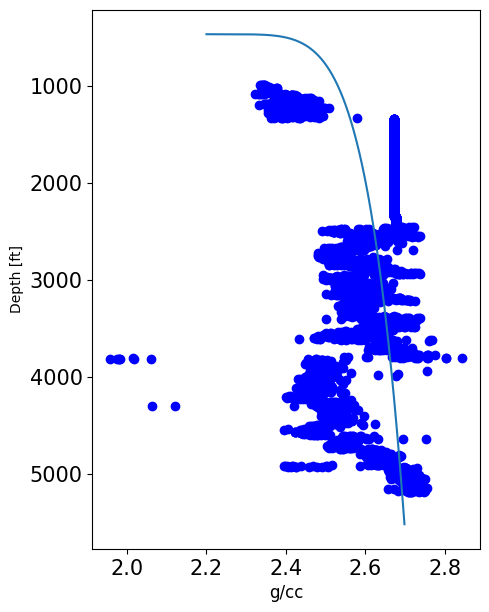

In [20]:
fig,ax=plt.subplots(figsize=(5,7))
ax.plot(Dens_trend,log['DEPTH'])
ax.scatter(log['RHOB'],log['DEPTH'], c='b',label='RHOB')
ax.set_xlabel('Density',fontsize='large')
ax.set_ylabel('Depth [ft]')
# ax.set_ylim(0,4400)
ax.invert_yaxis()
ax.set_xlabel('g/cc')

In [21]:
new_data = np.full_like(Dens_trend, np.nan)
new_data[0:958] = Dens_trend[0:958]
old_data = np.array(log['RHOB'])
new_data[958:4931] = old_data[958:4931]
new_data[4931:] = Dens_trend[4931:]

# new_data[27265:] =Dens_trend[27265:]
log['NewRHOB'] = new_data

Text(0.5, 0, 'g/cc')

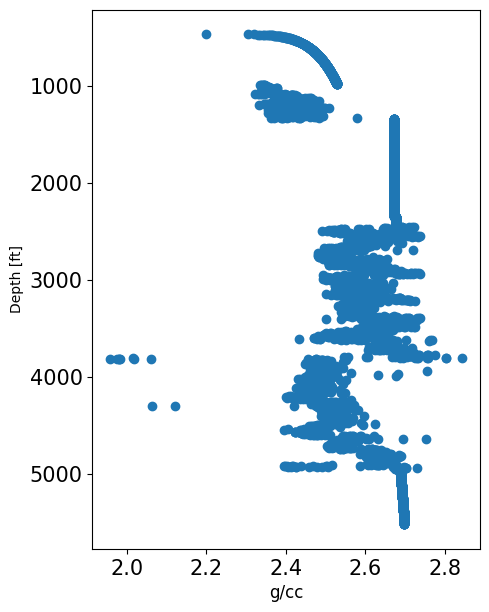

In [22]:
fig,ax=plt.subplots(figsize=(5,7))
# ax.plot(Dens_trend,log['DEPTH'])
ax.scatter(log.NewRHOB,log.DEPTH)
# ax.scatter(log['RHOB'],log['DEPTH'], c='b',label='RHOB')
ax.set_xlabel('Density',fontsize='large')
ax.set_ylabel('Depth [ft]')
# ax.set_ylim(0,4400)
ax.invert_yaxis()
ax.set_xlabel('g/cc')

In [23]:
def overburden_pressure(TVDs, bulk_density, p0 = 0):
    """"
    depth : depth in m
    density : bulk density in g/cc
    p0 : pressure at 0. If 0 is mudline -> p0 is mudline
    """
    g = 9.81
    dz = np.concatenate([np.array([np.diff(TVDs).mean()]),np.diff(TVDs)])
    return p0 + np.cumsum(bulk_density*1000*g*dz)

In [24]:
loglito=log.dropna(subset=['NewRHOB'])

In [25]:

log['Lithostatic_Pressure_at_bit']=overburden_pressure(TVDs=loglito['DEPTHSHIFT'], 
                                    bulk_density=loglito['NewRHOB'],
                                    p0 = P_mudline)
log['Overburden_Gradient'] = log['NewRHOB'] *g*d_seawater*1000 

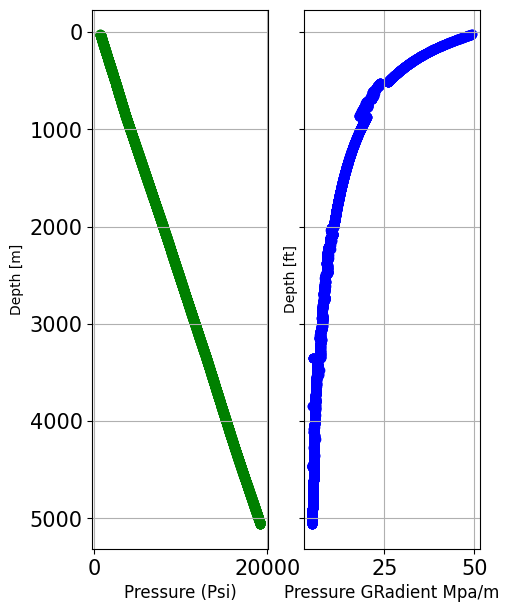

In [26]:
fig,axs=plt.subplots(1,2,figsize=(5,7),sharey=True)
ax=axs[0]
ax.scatter(log['Lithostatic_Pressure_at_bit']*(145.038/1e6),log['DEPTHSHIFT'],linestyle='-', c='g',label='Pressure')
ax.set_xlabel('Pressure (Psi)',fontsize='large')
ax.set_ylabel('Depth [m]')
ax.grid()
ax=axs[1]
ax.scatter(log['Overburden_Gradient']/log.DEPTH,log['DEPTHSHIFT'], c='b',label='Pressure/m')
ax.set_xlabel('Pressure GRadient Mpa/m',fontsize='large')
ax.set_ylabel('Depth [ft]')
ax.grid()
# ax.set_ylim(0,4300)
ax.invert_yaxis()

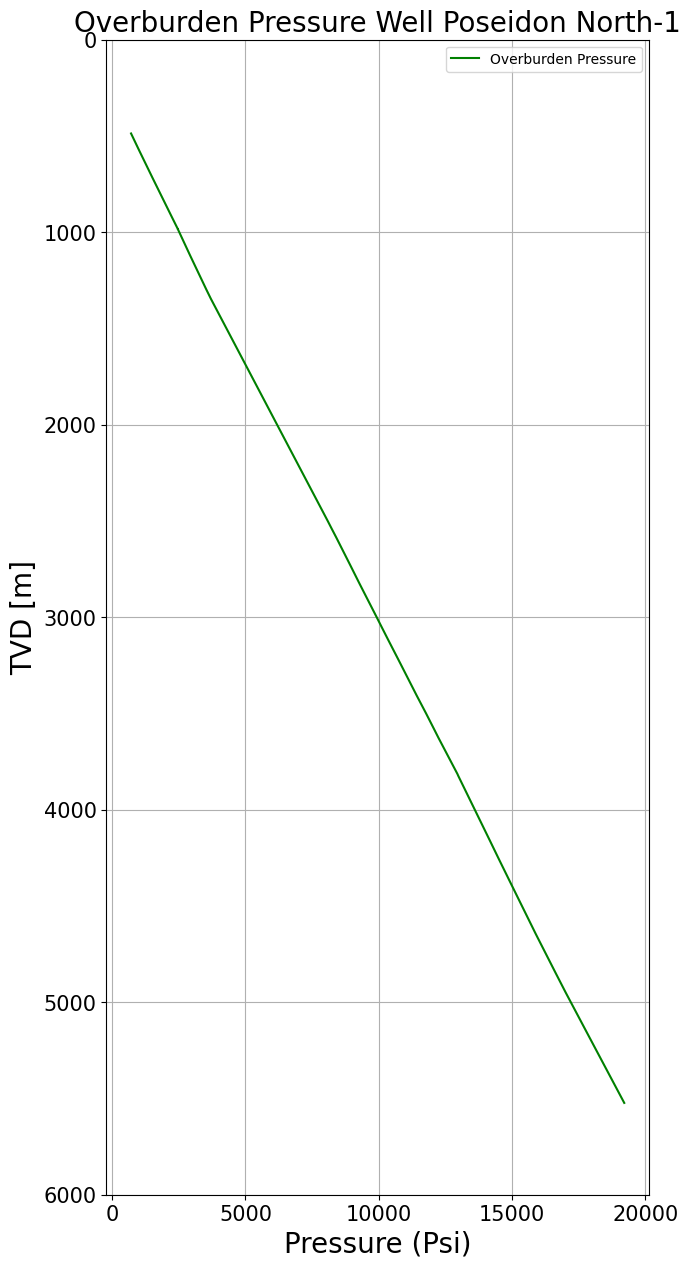

In [27]:
fig,ax=plt.subplots(figsize=(7,15))
ax.set_title("Overburden Pressure Well Poseidon North-1",fontsize=20)
ax.plot(log['Lithostatic_Pressure_at_bit']*(145.038/1e6),log['DEPTH'],linestyle='-', c='g',label='Overburden Pressure')
ax.set_xlabel('Pressure (Psi)',fontsize=20)
ax.set_ylabel('TVD [m]',fontsize=20)
plt.rcdefaults()
# change the fontsize of the xtick and ytick labels
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
ax.legend()
ax.grid()
ax.set_ylim(0,6000)
ax.invert_yaxis()

In [28]:
logshale = log[(log.DEPTH >= min(log.DEPTH)) & (log.DEPTH <= max(log.DEPTH)) & (log['GR'] > 75)]

# Determine Normal Compaction Trend

Defining Log Sonic in Shale Formation

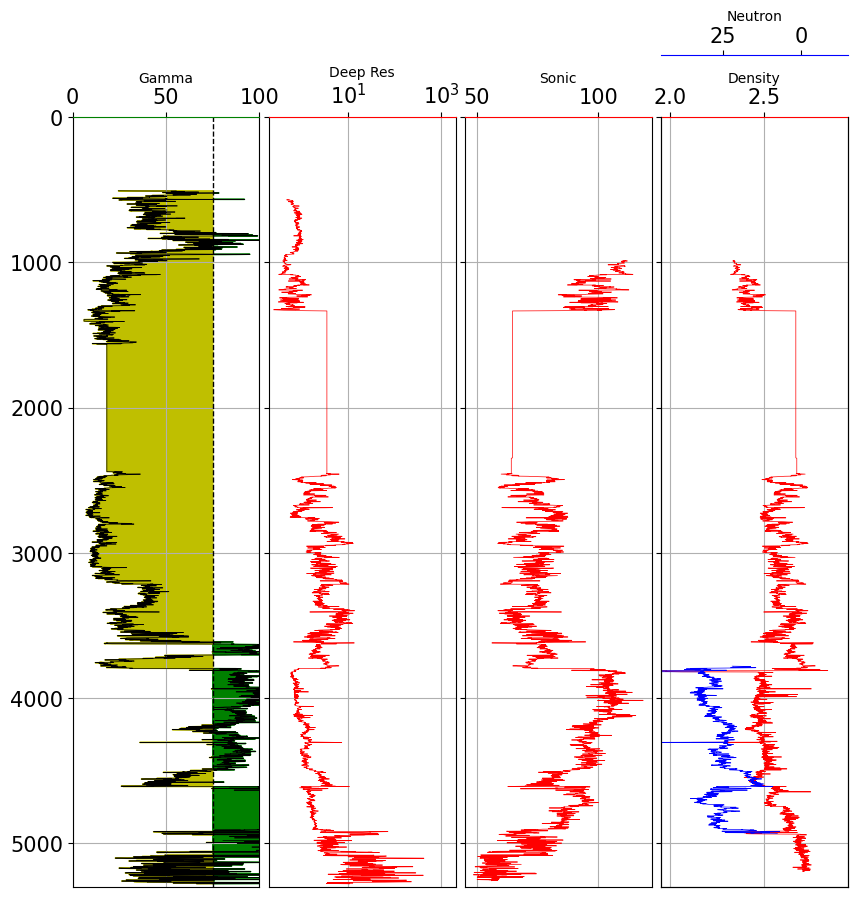

In [29]:
fig, axes = plt.subplots(figsize=(10,10))

curve_names = ['Gamma', 'Deep Res', 'Sonic', 'Density', 'Neutron']


#Set up the plot axes
ax1 = plt.subplot2grid((1,4), (0,0), rowspan=1, colspan = 1) 
ax2 = plt.subplot2grid((1,4), (0,1), rowspan=1, colspan = 1)
ax3= plt.subplot2grid((1,4), (0,2), rowspan=1, colspan = 1)
ax4 = plt.subplot2grid((1,4), (0,3), rowspan=1, colspan = 1)
ax5 = ax4.twiny()


#Set up the individual log tracks / subplots
ax1.plot("GR", "DEPTH", data = log, color = "k", lw = 0.5)
ax1.set_xlim(0, 100) 
ax1.spines['top'].set_edgecolor('green')
Cutoff=75
ax1.fill_betweenx(log['DEPTH'],log['GR'],Cutoff,
                           where=log['GR']>Cutoff,interpolate=True,color='g', label='shales')
ax1.fill_betweenx(log['DEPTH'],log['GR'],Cutoff,
                           where=log['GR']<Cutoff,interpolate=True,color='y', label='sands')
ax1.axvline(Cutoff,color='k',linewidth=1,linestyle='--')

ax2.plot("RES", "DEPTH", data = log, color = "red", lw = 0.5)
ax2.set_xlim(0.2, 2000)
ax2.semilogx()
ax2.spines['top'].set_edgecolor('red')

ax3.plot("DT:1", "DEPTH", data = log, color = "red", lw = 0.5)
ax3.spines['top'].set_edgecolor('red')

ax4.plot("RHOB", "DEPTH", data = log, color = "red", lw = 0.5)
ax4.set_xlim(1.95, 2.95)
ax4.spines['top'].set_edgecolor('red')

ax5.plot("NPHI", "DEPTH", data = log, color = "blue", lw = 0.5)
ax5.set_xlim(45, -15)
ax5.spines['top'].set_edgecolor('blue')


#Set up the common elements between the subplots
for i, ax in enumerate(fig.axes):
    ax.set_ylim(0, 5300) # Set the depth range
    
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")
    ax.set_xlabel(curve_names[i])
    ax.invert_yaxis()
    if i == 4:
        ax.spines["top"].set_position(("axes", 1.08))
    else:
        ax.grid()
        

#Hide tick labels on the y-axis 
for ax in [ax3, ax4]:
    plt.setp(ax.get_yticklabels(), visible = False)
for ax in [ax2, ax3]:
    plt.setp(ax.get_yticklabels(), visible = False)
#Reduce the space between each subplot
fig.subplots_adjust(wspace = 0.05)

In [30]:
def med_filt(window=4000):
    min_per = 1 # to avoid getting NaN if there is a single NaN, I request to have at least min_per real numbers in the window
    log[f'DT_{window}']= log['DT:1'].rolling(window,min_periods=min_per, center=True).median()
med_filt(30)
med_filt(100)

Text(0.5, 0.98, 'NCT')

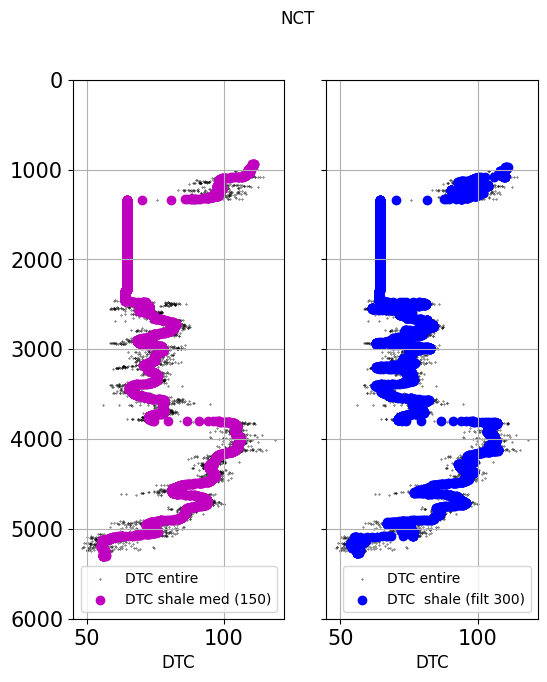

In [31]:
fig,ax=plt.subplots(1,2, sharey=True,figsize=(6,7))

ax[0].scatter(log['DT:1'],log['DEPTH'], c='k',label='DTC entire',s=0.1)
ax[0].scatter(log['DT_100'],log['DEPTH'], c='m',label='DTC shale med (150)')
ax[0].set_xlabel('DTC',fontsize='large')

ax[1].scatter(log['DT:1'],log['DEPTH'], c='k',label='DTC entire',s=0.1)
ax[1].scatter(log['DT_30'],log['DEPTH'],c='b',label='DTC  shale (filt 300)')
ax[1].set_xlabel('DTC',fontsize='large')
for a in ax:
    a.grid(True)
    a.legend(loc='lower right')
    a.set_ylim(0,6000)
    a.invert_yaxis()
fig.suptitle('NCT')

1.0017602325173627 71.00028545654503


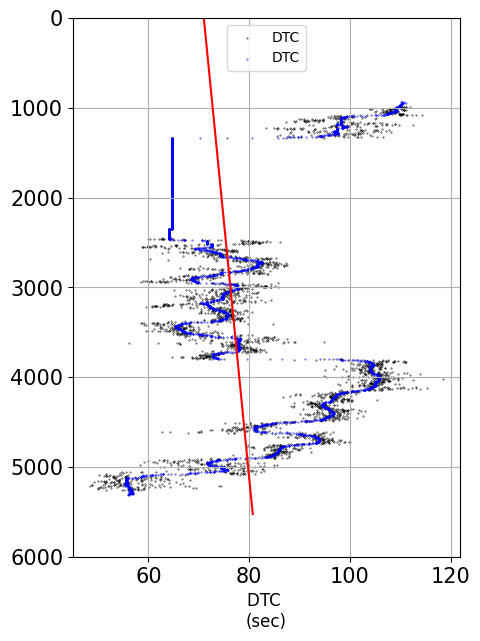

In [32]:
fig,ax=plt.subplots(figsize=(5,7))


ax.scatter(log['DT:1'],log['DEPTH'],c='black',label='DTC', s=0.1)
ax.scatter(log['DT_100'],log['DEPTH'],c='b',label='DTC', s=0.1)
ax.set_xlabel('DTC \n(sec)',fontsize='large')
ax.legend(loc='upper center')
ax.grid()
ax.invert_yaxis()

n_smooth = 150
x_unit_trend=log['DT_100'].rolling(n_smooth).median()
y_unit_trend=log['DEPTH'].rolling(n_smooth).median()
# # remove the nans
x_unit_trend=np.where(x_unit_trend<0.01,np.nan,x_unit_trend) # remove the 0
mask = ~np.isnan(x_unit_trend)
x_unit_trend=x_unit_trend[mask]
y_unit_trend=y_unit_trend[mask]
mask = ~np.isnan(y_unit_trend)
x_unit_trend=x_unit_trend[mask]
y_unit_trend=y_unit_trend[mask]

fit_data = (y_unit_trend>0)&(y_unit_trend<4000)
pol_fit = np.polyfit(y_unit_trend[fit_data],x_unit_trend[fit_data],1)

Rn_extrap = np.polyval(pol_fit,log['DEPTH'])

ax.plot(Rn_extrap,log['DEPTH'],'red',label='Dn (unit)')
ax.set_ylim(0,6000)
ax.invert_yaxis()
slope = pol_fit[0]
intercept = pol_fit[1]

print (np.exp(slope), intercept)

In [33]:
def DTc_NCT (DTm,DTml, TVDs, c=70.32129255e-06):
    
    """
    DESCRIBE IN A FEW WORDS WHAT YOU WANT TO DO
    Estimate the normal compaction DT for any depth
    input is depth
    DTml, DTm and c are parameters
    
    DTm = Transit time in Shale matrix us/m
    Intercept = DTml = Transit time in Mudline (z=0) us/m
    1/c = characteristic compaction depth 
    z: depth mbsf
    """  
    return DTm + (DTml - DTm) *  np.exp(-c*TVDs)

In [34]:
fit_interval = [0,5000] # numbers obtained from the plot above 

def error_DT(x):
    """
    We want to mimize the mismatch (DT(z)-DTmeasured)**2 
    summed over the fit interval
    
    x is [DTml, DTm,c]
    
    y_unit_trend: input -> depth
    x_unit_trend: ouput -> DT
    """
    mask = (y_unit_trend>fit_interval[0])&(y_unit_trend<fit_interval[1])
    pred = np.array([DTc_NCT(x[0], x[1],z, x[2]) for z in y_unit_trend[mask]])
    return np.sqrt(np.sum((pred-x_unit_trend[mask])**2))

In [35]:
estimate_value=[1.000000626260348,166.61230573880167,-0.015333773657322105]
error_DT(estimate_value)

1.873315822552927e+36

In [36]:
from scipy.optimize import minimize

res = minimize(error_DT, x0=estimate_value)
print(res)

      fun: 888.1033325787153
 hess_inv: array([[ 2.22703351e-01,  3.43859725e-13, -2.70720820e-07],
       [ 3.43859725e-13,  1.00000000e+00,  1.21561393e-06],
       [-2.70720820e-07,  1.21561393e-06,  1.80680864e-12]])
      jac: array([0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 7
     njev: 9
   status: 0
  success: True
        x: array([ 79.45718641, 166.61230451,   0.99457085])


In [37]:
def DTc_NCTL (DTm, DTml,TVDs, c=70.32129255e-05): 
    
    """
    DESCRIBE IN A FEW WORDS WHAT YOU WANT TO DO
    Estimate the normal compaction DT for any depth
    input is depth
    DTml, DTm and c are parameters
    
    DTm = Transit time in Shale matrix us/m
    Intercept = DTml = Transit time in Mudline (z=0) us/m
    1/c = caracterstic compaction depth 
    z: depth mbsf
    """  
    return DTm + (DTml - DTm) *  np.exp(-c*TVDs) 

In [38]:
logshale = log[(log.DEPTH >= 3500) & (log.DEPTH <= max(log.DEPTH)) & (log['GR']>75 ) ]

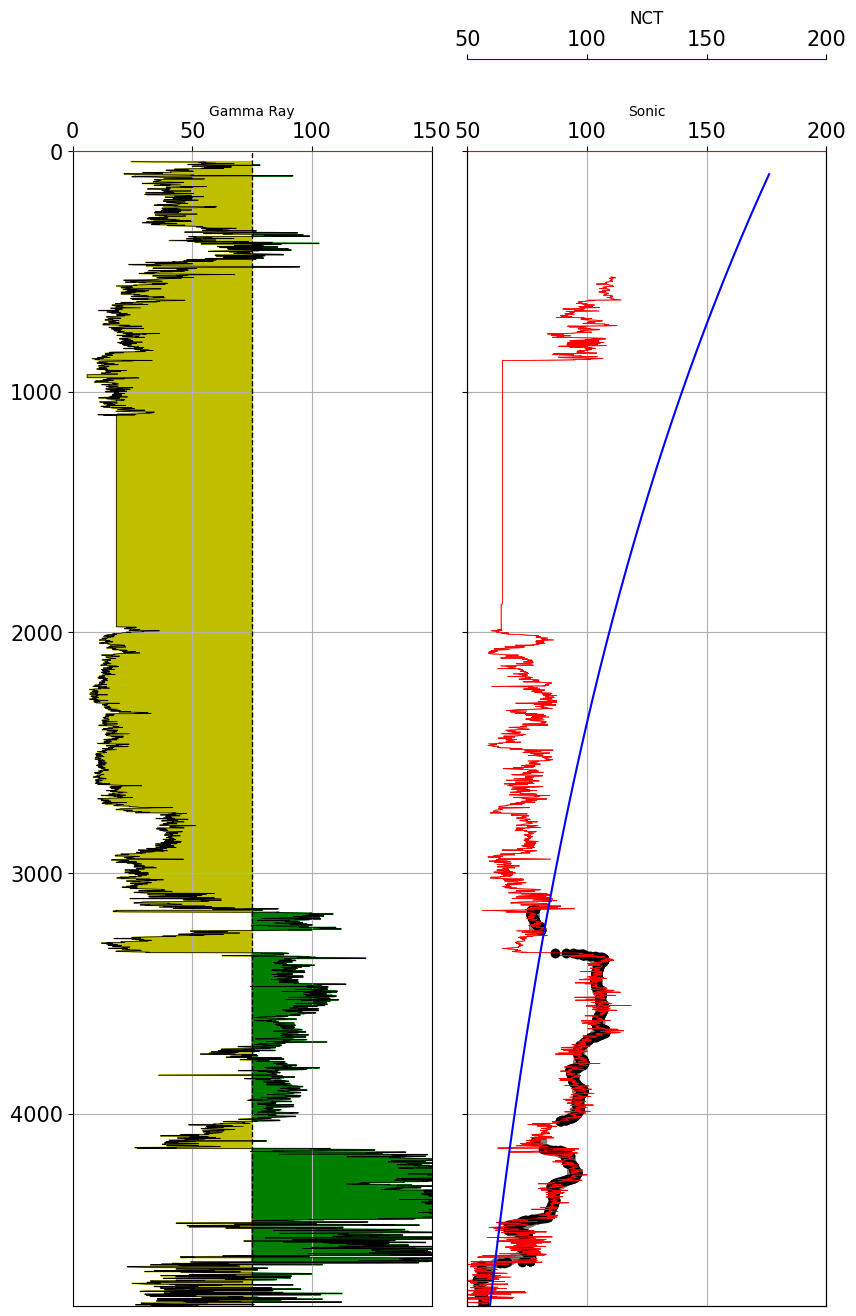

In [39]:
fig, axes = plt.subplots(figsize=(25,15))

curve_names = ['Gamma Ray','Sonic', 'NCT']


#Set up the plot axes
ax1 = plt.subplot2grid((1,5), (0,0), rowspan=1, colspan = 1) 
ax2 = plt.subplot2grid((1,5), (0,1), rowspan=1, colspan = 1)
ax3= ax2.twiny()


#Set up the individual log tracks / subplots
ax1.plot("GR", "DEPTHSHIFT", data = log, color = "k", lw = 0.5)
ax1.set_xlim(0, 150) 
ax1.spines['top'].set_edgecolor('green')
Cutoff=75
ax1.fill_betweenx(log['DEPTHSHIFT'],log['GR'],Cutoff,
                           where=log['GR']>Cutoff,interpolate=True,color='g', label='shales')
ax1.fill_betweenx(log['DEPTHSHIFT'],log['GR'],Cutoff,
                           where=log['GR']<Cutoff,interpolate=True,color='y', label='sands')
ax1.axvline(Cutoff,color='k',linewidth=1,linestyle='--')

ax2.plot("DT:1", "DEPTHSHIFT", data = log, color = "red", lw = 0.5)
ax2.spines['top'].set_edgecolor('red')
ax2.set_xlim(50,200)
ax3.plot("DT:1","DEPTHSHIFT",data=log,color='red', lw=0.5)
ax3.scatter("DT_100","DEPTHSHIFT",data=logshale, c='grey',label='DTc Shale')
ax3.scatter("DT_30","DEPTHSHIFT",data=logshale, c='black',label='DTc Shale')
ax3.set_xlabel('DT(us/ft)',fontsize='large')
ax3.spines['top'].set_edgecolor('blue')
ax3.set_xlim(50,200)
n_smooth = 150
x_unit_trend=log['DT:1'].rolling(n_smooth).median()
y_unit_trend=(log['DEPTHSHIFT']).rolling(n_smooth).median()
mask = (y_unit_trend>fit_interval[0])&(y_unit_trend<fit_interval[1])
x=[20.60228734, 180.61230556,  2.95000e-04]
pred = np.array([DTc_NCTL(x[0], x[1], z,x[2]) for z in y_unit_trend])
ax3.plot(pred,y_unit_trend,'blue',label='NCT Shale')

#Set up the common elements between the subplots
for i, ax in enumerate(fig.axes):
    ax.set_ylim(0, 4800) # Set the depth range

    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")
    ax.set_xlabel(curve_names[i])
    ax.invert_yaxis()
    if i == 2:
        ax.spines["top"].set_position(("axes", 1.08))
    else:
        ax.grid()
        

#Hide tick labels on the y-axis 

for ax in [ax2, ax3]:
    plt.setp(ax.get_yticklabels(), visible = False)

#Reduce the space between each subplot
fig.subplots_adjust(wspace = 0.10)

# Eaton Metode

In [40]:
# Populating NCT to the dataframe
DTm = 25.60228734
DTml = 180.61230556
c=2.95000e-04
log['DTc_NCT'] = DTc_NCTL (DTm, DTml, log['DEPTHSHIFT'],c=c) 
log['DTc_NCT'].describe()

count    5038.000000
mean      105.795542
std        33.801728
min        60.453389
25%        76.132100
50%        98.864302
75%       131.823200
max       179.609548
Name: DTc_NCT, dtype: float64

In [41]:
def compute_PPG_from_Eaton_Transit (obg,hbg,DTc_NCT,DT, Eaton_coefficient = 3):
    """
    OBG = Overburden gradient = Lithostatic_Pressure_Gradient
    HBG = Hydrostatic_Pressure_Gradient
    DTc = shale resistivity
    DT = shale resistivity Normal trend line 
    """
    return obg-(obg-hbg)*(DTc_NCT/DT)**Eaton_coefficient

In [42]:
DTc_NCT_from_TVD = interp1d(log['DEPTHSHIFT'],
                        log['DTc_NCT'],
                                      fill_value='extrapolate')
DTc_NCT= DTc_NCT_from_TVD(log['DEPTHSHIFT'])
print(f"Shape of DTc_NCT {DTc_NCT.shape} min: {DTc_NCT.min()} max: {DTc_NCT.max()} mean: {DTc_NCT.mean()}")

Shape of DTc_NCT (5502,) min: nan max: nan mean: nan


In [43]:
def compute_ppg_from_TVD(TVDs,DT_column='DT_300',log=log,
                         obg = log['Overburden_Gradient'],
                         hbg=log['Hydrostatic_Pressure_Gradient'],Eaton_coefficient=3):
    df_clean = log[log[DT_column].notna()].copy() # Mai : remove nan
    DT_from_TVD = interp1d(df_clean['DEPTHSHIFT'],
                            df_clean[DT_column],
                            fill_value=(df_clean.loc[df_clean.index[0],DT_column],
                                        df_clean.loc[df_clean.index[-1],DT_column]),bounds_error=False) # Mai : avoid excentric data at the end
#                            fill_value='extrapolate')
    DT = DT_from_TVD(log['DEPTHSHIFT'])
    mask = np.isnan(DT)
    DT[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), DT[~mask])
    return compute_PPG_from_Eaton_Transit (obg,hbg,DTc_NCT,DT,
                                              Eaton_coefficient=Eaton_coefficient)

def put_ppg_above_hydrostatic(ppg, d_water = d_seawater):
    """    
    If PPG is less than hydrostatic, it is put above hydrostatic
    """
    return np.where(ppg<d_water*1000*g,d_water*1000*g,ppg)

def put_ppg_to_hydrostatic_on_top(ppg,zlim=0,z=log['DEPTHSHIFT'], d_water = d_seawater):
    """    
    If depth is less than a threshold depth, ppg is set to hydrostatic
    """
    return np.where(z<0,d_water*1000*g,ppg)

def compute_pore_pressure_from_TVD(TVDs,DT_column='DT_300',
                                   hydro_until=None,Eaton_coefficient=1.2):
    ppg = compute_ppg_from_TVD(TVDs,DT_column=DT_column,Eaton_coefficient=Eaton_coefficient)
    if hydro_until is not None:
        ppg = put_ppg_to_hydrostatic_on_top(ppg,zlim=hydro_until)
    p = P_mudline + ppg * TVDs
    return p,ppg
top_hydro = 0

In [44]:
top_hydro = 0
ppg_100_DT = compute_ppg_from_TVD(TVDs = log['DEPTHSHIFT'],DT_column='DT_100')
ppg_300_DT = compute_ppg_from_TVD(TVDs = log['DEPTHSHIFT'],DT_column='DT_30')
ppg_raw_DT = compute_ppg_from_TVD(TVDs = log['DEPTHSHIFT'],DT_column='DT:1',)

pore_pressure_100_DT,ppg_100_DT_cut = compute_pore_pressure_from_TVD(log['DEPTHSHIFT'],DT_column='DT_100',hydro_until=top_hydro)
pore_pressure_300_DT,ppg_300_DT_cut = compute_pore_pressure_from_TVD(log['DEPTHSHIFT'],DT_column='DT_30',hydro_until=top_hydro)
pore_pressure_raw_DT,ppg_raw_DT_cut = compute_pore_pressure_from_TVD(log['DEPTHSHIFT'],DT_column='DT:1',hydro_until=top_hydro)

In [45]:
# ....................PPG..........................
pore_pressure_gradient_interpolation_raw= interp1d(log['DEPTHSHIFT'],ppg_raw_DT,fill_value='extrapolate')
log['Pore_Pressure_gradient_DT_raw']=pore_pressure_gradient_interpolation_raw(log['DEPTHSHIFT'])
# df['Pore_Pressure_gradient_DT_raw']=df['Pore_Pressure_gradient_DT_raw'].iloc[2300:121500]

# .....................PORE_PRESSURE_.....................................
pore_pressure_interpolation_raw=interp1d(log['DEPTHSHIFT'],pore_pressure_raw_DT,fill_value='extrapolate')
log['Pore_Pressure_Estimated_DT_raw']=pore_pressure_interpolation_raw(log['DEPTHSHIFT'])
# df['Pore_Pressure_Estimated_DT_raw']=df['Pore_Pressure_Estimated_DT_raw'].iloc[2300:121500]

# ......................PORE_PRESSURE_Sampled_1500_points....................................
pore_pressure_interpolation_300=interp1d(log['DEPTHSHIFT'],pore_pressure_300_DT,fill_value='extrapolate')
log['Pore_Pressure_Estimated_DT_30']=pore_pressure_interpolation_300(log['DEPTHSHIFT'])
pore_pressure_interpolation_100=interp1d(log['DEPTHSHIFT'],pore_pressure_100_DT,fill_value='extrapolate')
log['Pore_Pressure_Estimated_DT_100']=pore_pressure_interpolation_100(log['DEPTHSHIFT'])
# df['Pore_Pressure_Estimated_DT']=df['Pore_Pressure_Estimated_DT'].iloc[2300:121500]

In [46]:
log['PPG_raw']=(log['Pore_Pressure_Estimated_DT_raw']*(145.038/1e6))/0.052/(log['DEPTH']*3.2808399)
log['PPG_30']=(log['Pore_Pressure_Estimated_DT_30']*(145.038/1e6))/0.052/(log['DEPTH']*3.2808399)

In [47]:
new=put_ppg_above_hydrostatic(ppg_100_DT_cut, d_water = d_seawater)

In [48]:
log['PPFinal']=new*log.DEPTH*(145.038/1e6)
log['PPGFinal']=log['PPFinal']/0.052/(log['DEPTH']*3.2808399)

In [49]:
# maskingindex=7364
# new_data = np.full_like(log.Hydrostatic_Pressure_at_bit, np.nan)
# new_data[0:maskingindex] = log.Hydrostatic_Pressure_at_bit[0:maskingindex]
# old_data = np.array(log['Pore_Pressure_Estimated_DT_300'])
# new_data[maskingindex:] = old_data[maskingindex:]
# log['PPFinal'] = new_data

In [50]:
mdt = pd.read_csv('F:/Poseidon/Python Poseidon/Pressure Data/excel//5. Poseidon North MDT&XPT/Poseidon North MDT.csv', delimiter=';')
print(mdt)
depthshiftmdt=mdt['Pretest DEPTH TVDMSL']-486

   Pretest DEPTH MD  Pretest DEPTH TVDMSL  Final Pressure (Psia)
0            4921.9                4898.4                 9851.3
1            4923.6                4900.1                 9860.4
2            4924.8                4901.3                 9864.4
3            4924.8                4901.3                 9864.4
4            4932.1                4908.6                 9924.8
5            4933.8                4910.3                 9932.9
6            4933.8                4910.3                 9834.5
7            4934.3                4910.8                 9930.8
8            4935.0                4911.5                 9950.4


In [51]:
logshale = log[(log.DEPTH >= 3000) & (log.DEPTH <= max(log.DEPTH)) & (log['GR'] >75) ]

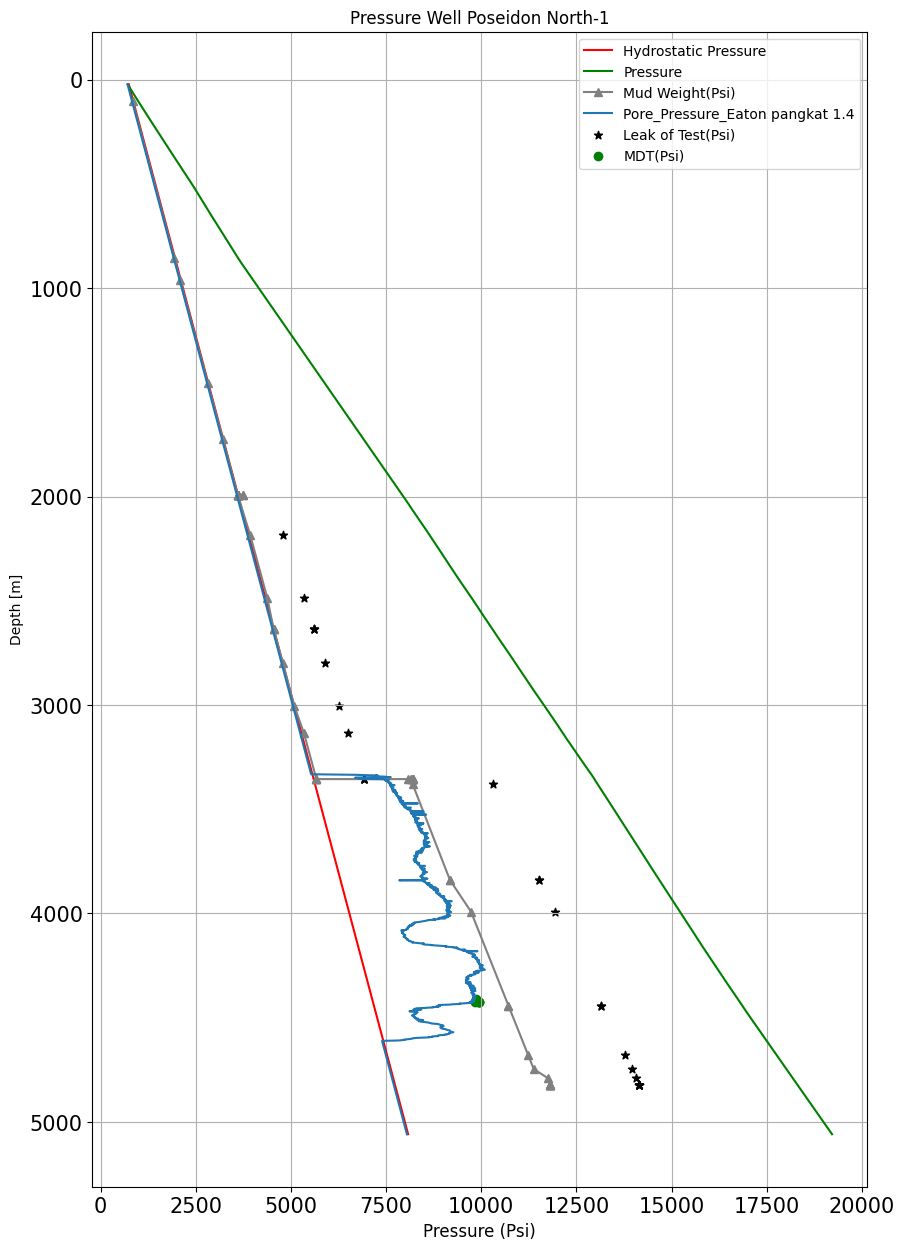

In [52]:
fig,ax=plt.subplots(figsize=(10,15))
ax.set_title("Pressure Well Poseidon North-1")
ax.plot(log['Hydrostatic_Pressure_at_bit']*(145.038/1e6),log['DEPTHSHIFT'],linestyle='-', c='r',label='Hydrostatic Pressure')
ax.plot(log['Lithostatic_Pressure_at_bit']*(145.038/1e6),log['DEPTHSHIFT'],linestyle='-', c='g',label='Pressure')
ax.plot(df2['Mud Weight(psi) TVD'],depthshiftmud,marker='^',color = 'gray',label='Mud Weight(Psi)')
ax.scatter(df1['LOT (psi) TVD'],depthshiftlot,marker='*',color = 'black',label='Leak of Test(Psi)')
ax.scatter(mdt['Final Pressure (Psia)'],depthshiftmdt,label='MDT(Psi)',color = 'green')
ax.plot(log['PPFinal'],log.DEPTHSHIFT,label='Pore_Pressure_Eaton pangkat 1.4')
ax.set_xlabel('Pressure (Psi)',fontsize='large')
ax.set_ylabel('Depth [m]')
ax.grid()
ax.legend()
ax.invert_yaxis()

### IMPORT FILE WELL TO EXCEL

In [53]:
logshale= log[(log.DEPTH >= min(log.DEPTH)) & (log.DEPTH <= 4800) & (log['GR'] > 75)]

In [54]:
logplot= logshale[['DEPTH','DEPTHSHIFT','GR', 'RHOB','NPHI','DT:1','SDT','RES','PPFinal','PPGFinal']]

In [55]:
show_PPG=log[(log.DEPTH >= 3797) & (log.DEPTH <= 4996) ]

In [56]:
print(max(show_PPG['PPFinal']))
print(min(show_PPG['PPFinal']))
print(max(show_PPG['PPGFinal']))
print(min(show_PPG['PPGFinal']))

10094.718715643925
5876.540599666861
12.56198880350355
9.07178527610807


In [57]:
# logplot.to_excel(r'E:\Poseidon\Crossplot sensitive of Overpressure/New Data/Crossplot/PoseidonNorthShale-1.xlsx',sheet_name='Poseidon North', index=False)

In [58]:
# NEw=logshale[['GR', 'RHOB','NPHI','DT','SDT','RES:1','PPG_30']]


In [59]:
# NEw.to_csv(r'E:\Poseidon\Crossplot sensitive of Overpressure\PoseidonNorthNewShale-1.csv', index=False)

In [60]:
logcalpp=log[['DEPTH','DEPTHSHIFT','DTc_NCT','Lithostatic_Pressure_at_bit','Hydrostatic_Pressure_at_bit','PPFinal','PPGFinal']]

In [61]:
logcalpp.to_excel(r'F:/Poseidon/Python Poseidon/Crossplot sensitive of Overpressure/New Data\Analisis All Well/Poseidon North-1 PP Eaton.xlsx',sheet_name='Poseidon North', index=False)

In [62]:
# log.to_excel(r'F:\Poseidon\Python Poseidon\Well Conditioning\Poseidon North-1 .xlsx',sheet_name='Poseidon North', index=False)

### IMPORT TOPS WELL


In [63]:
top=pd.read_csv('F:/Poseidon/Python Poseidon/Pressure Data/2.Top Formation/Poseidon North TOP.csv', delimiter=';')

In [64]:
Depthshifttop=abs(top['TVDSS'])-486+60
toptvdss=np.zeros(len(top['MDRT\n']))
nametop=[top['Formation Name']]
print(nametop)
labs = ['Piertszoon / Sea Bed'
                ,'Tasman Marl Member top'
                 , 'Oliver Formation top'
     ,'Van Der Wall Limestone Member top'
                 ,'Read Limestone Member'
          ,'Dampier Limestone Member top'
        ,'Allouarn Limestone Member top'
              ,'Heywood Limestone Member'
                ,'Baudin Marl Member top'
                 ,'Johnson Formation top'
                     ,'Johnson Sand Mbr'
                   ,'WGFP Formation top'
               ,'Jamieson Formation top'
          ,'Echuca Shoals Formation top'
               ,'Brewster Shale Mbr top'
                     , 'Montara Mbr top'
                       ,'Golden Mbr top'
                  ,'Triassic (Nome) top'
               ,'Triassic (Challis) top'
                                   ,'TD']

[0                  Piertszoon I Sea Bed
1                Tasman Marl Member top
2                  Oliver Formation top
3     Van Der Wall Limestone Member top
4                 Read Limestone Member
5          Dampier Limestone Member top
6         Allouarn Limestone Member top
7              Heywood Limestone Member
8                Baudin Marl Member top
9                 Johnson Formation top
10                     Johnson Sand Mbr
11                   WGFP Formation top
12               Jamieson Formation top
13          Echuca Shoals Formation top
14               Brewster Shale Mbr top
15                      Montara Mbr top
16                       Golden Mbr top
17                  Triassic (Nome) top
18               Triassic (Challis) top
19                                   TD
Name: Formation Name, dtype: object]


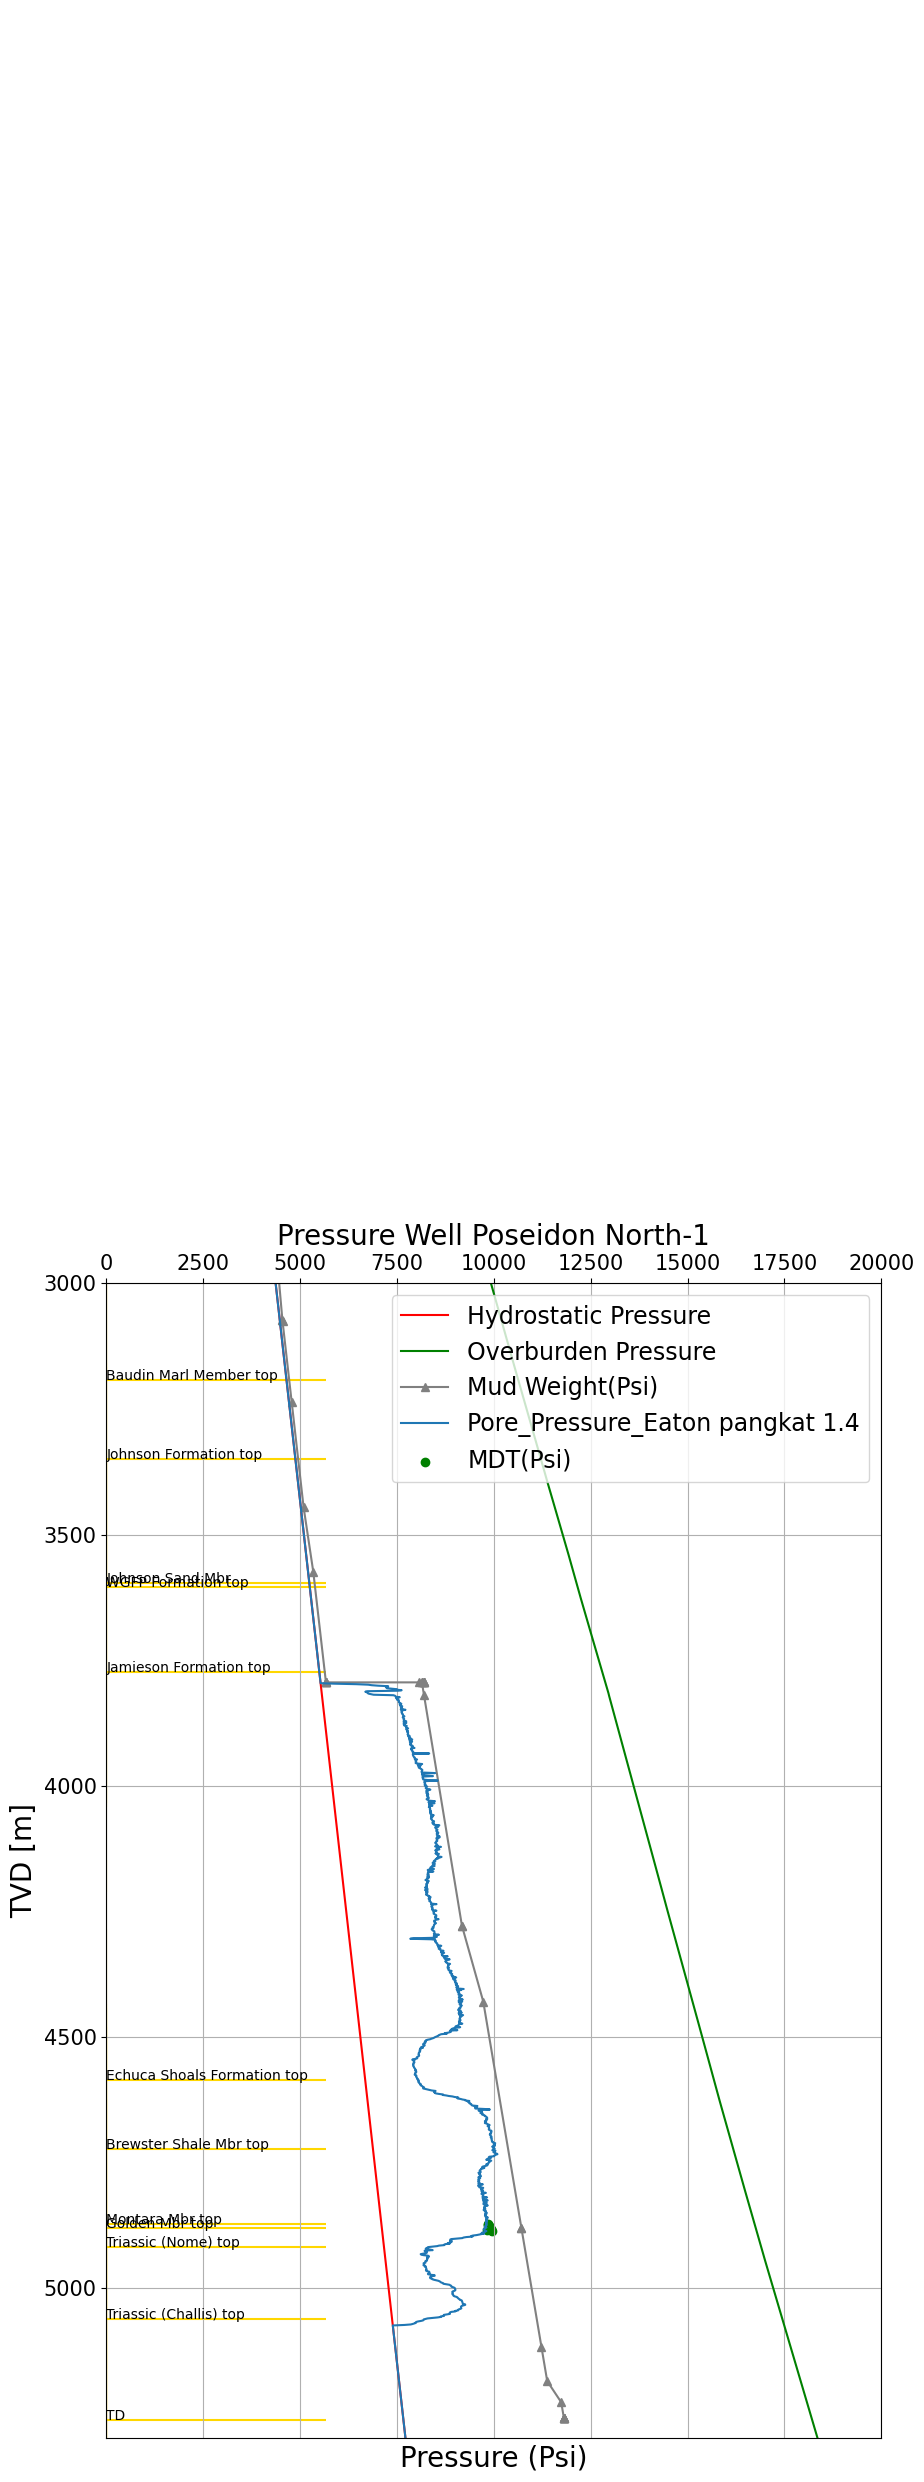

In [65]:
fig,ax=plt.subplots(figsize=(10,15))
ax.set_title("Pressure Well Poseidon North-1",fontsize=20)
ax.plot(log['Hydrostatic_Pressure_at_bit2']*(145.038/1e6),log['DEPTH'],linestyle='-', c='r',label='Hydrostatic Pressure')
ax.plot(log['Lithostatic_Pressure_at_bit']*(145.038/1e6),log['DEPTH'],linestyle='-', c='g',label='Overburden Pressure')
ax.plot(df2['Mud Weight(psi) TVD'],df2['TVDRT (m)']-25,marker='^',color = 'gray',label='Mud Weight(Psi)')
ax.scatter(mdt['Final Pressure (Psia)'],mdt['Pretest DEPTH TVDMSL']-25,label='MDT(Psi)',color = 'green')
ax.plot(log['PPFinal'],log.DEPTH,label='Pore_Pressure_Eaton pangkat 1.4')
ax.set_xlabel('Pressure (Psi)',fontsize=20)
ax.set_ylabel('TVD [m]',fontsize=20)
ax.set_xlim(0,20000)
for i, ax in enumerate(fig.axes):
    ax.set_ylim(3000, 5300) # Set the depth range
    ax.scatter(toptvdss,abs(top['TVDSS']),marker="+",s=100000,c="gold")
    ax.xaxis.set_ticks_position("top")
for i, txt in enumerate(labs):
    ax.annotate(txt, (toptvdss[i],abs(top['TVDSS'])[i]))

ax.grid()
ax.legend(loc='upper right',fontsize=17)
ax.invert_yaxis()

In [66]:
logshale = log[(log.DEPTH >= 3000) & (log.DEPTH <= max(log.DEPTH)) & (log['GR'] >75) ]

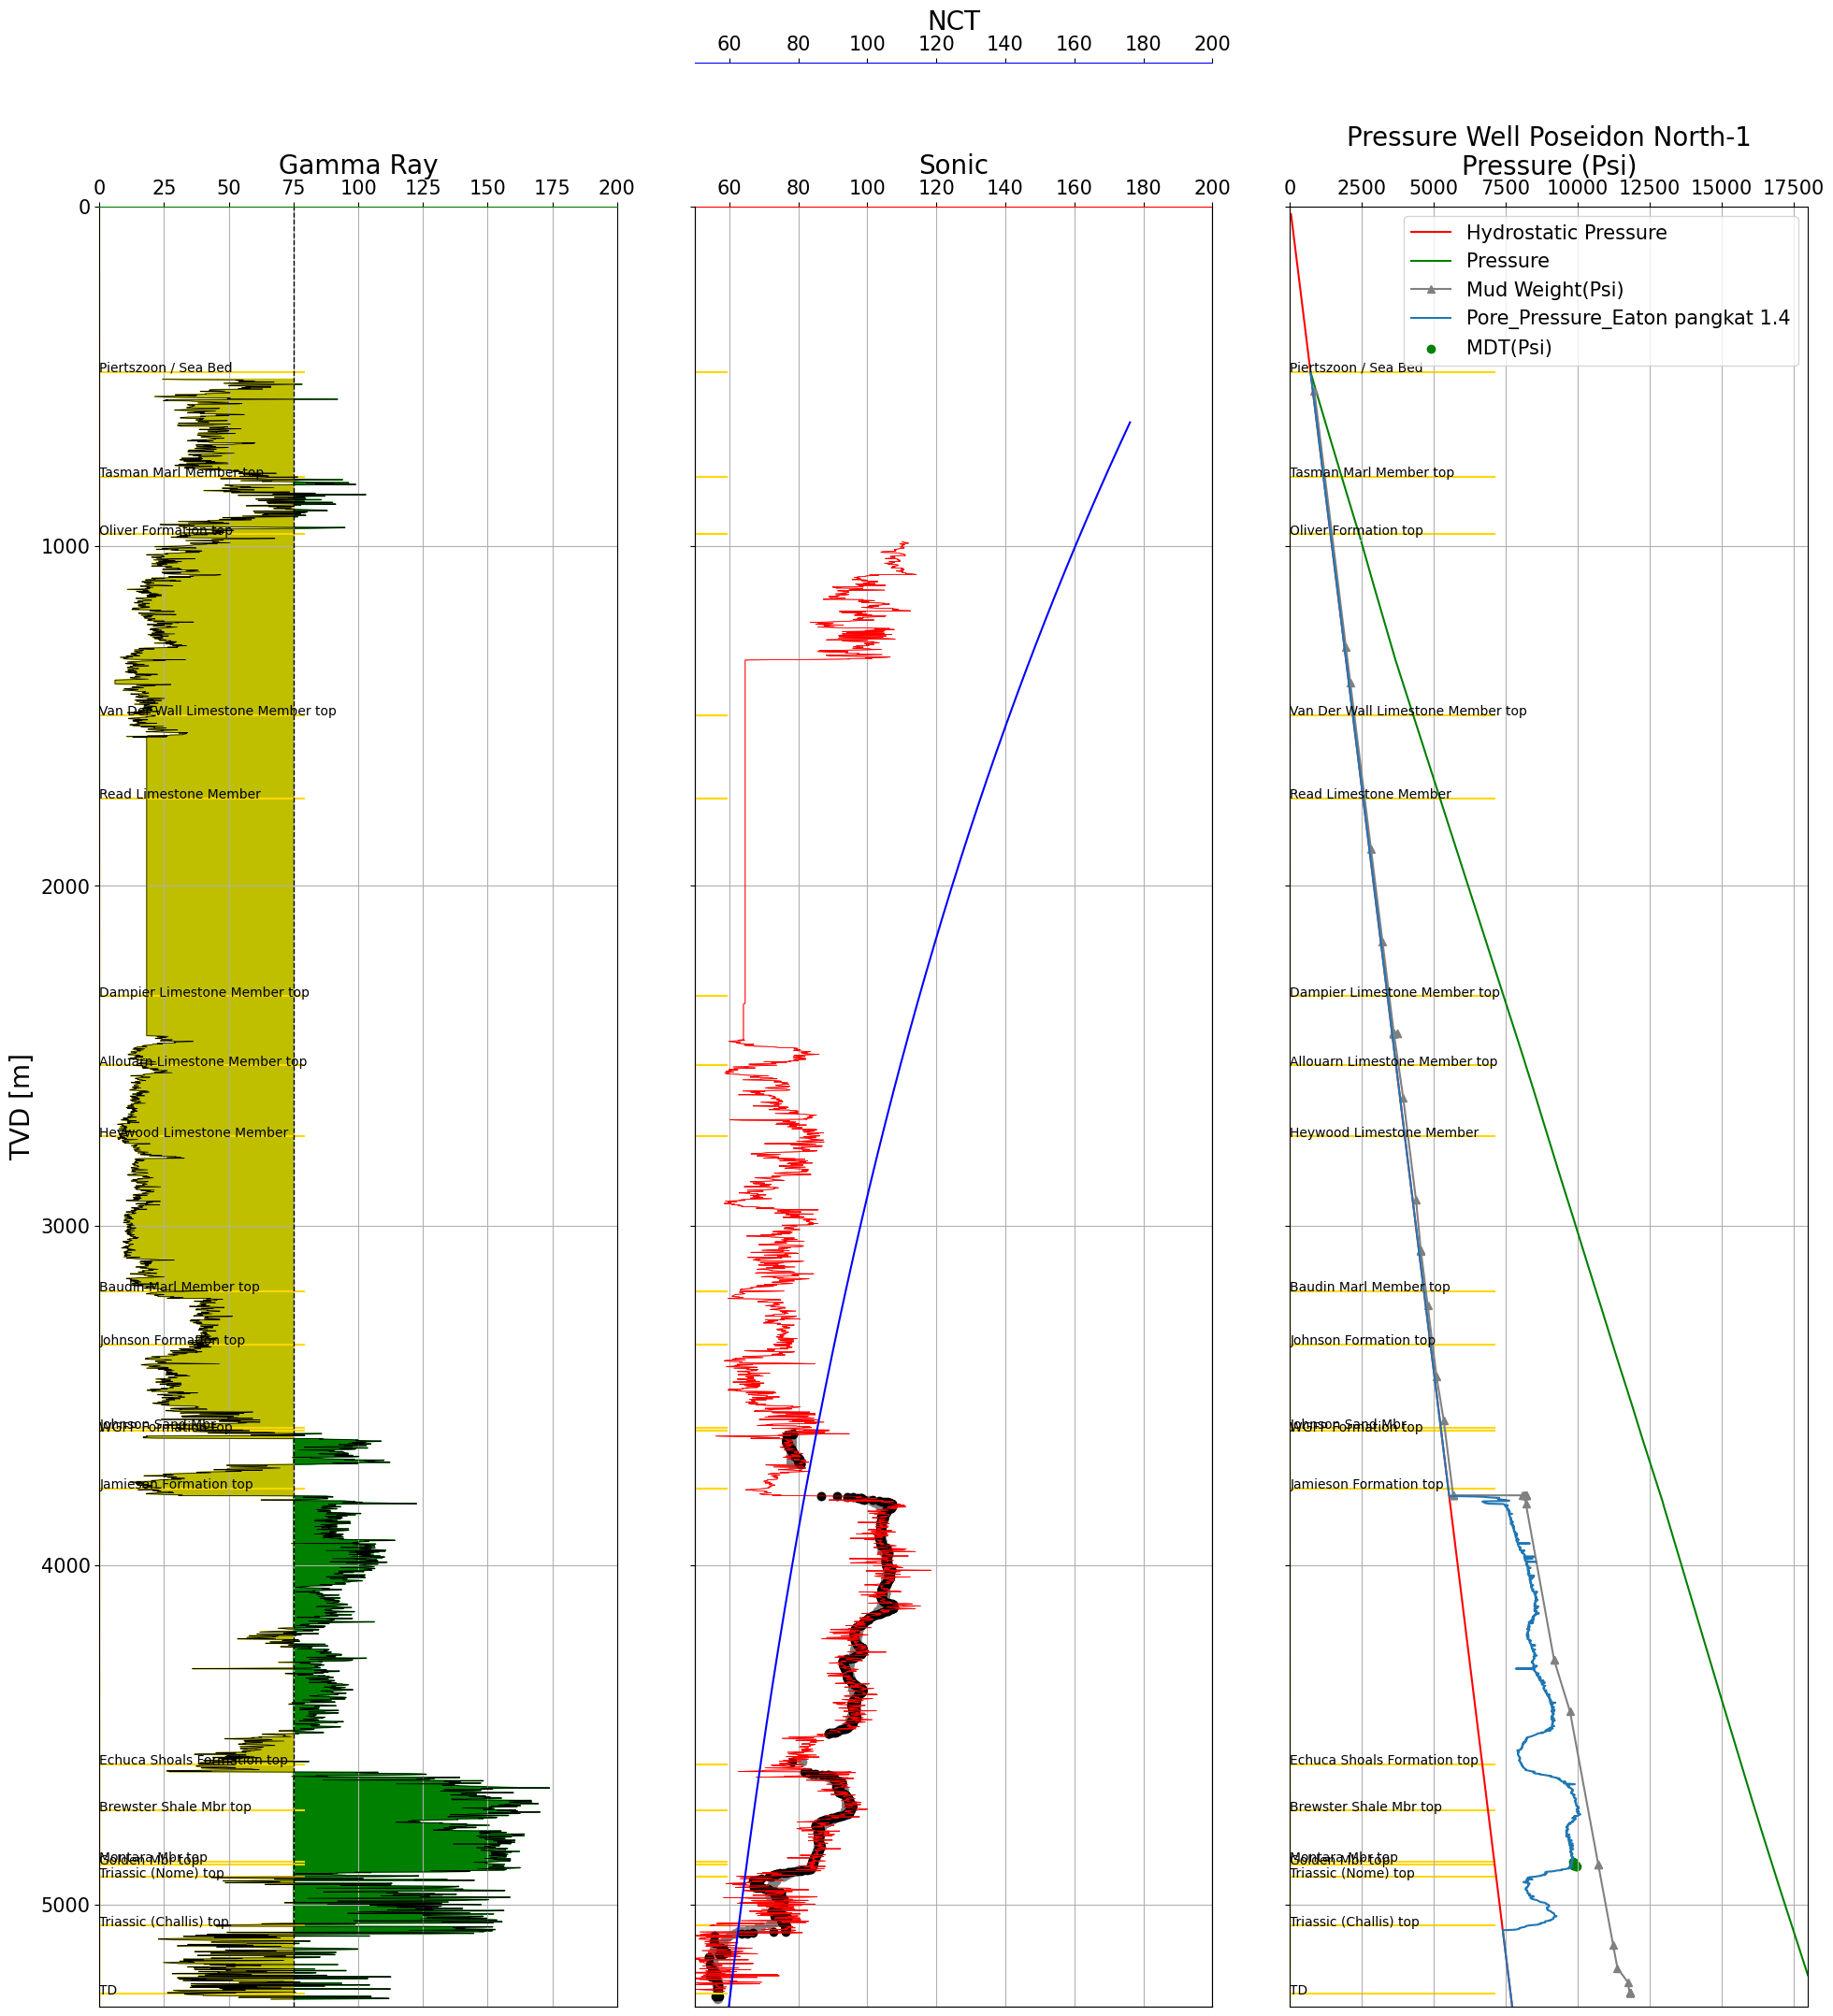

In [67]:
fig, axes = plt.subplots(figsize=(40,25))

curve_names = ['Gamma Ray','Sonic', 'NCT','PPP']


#Set up the plot axes
ax1 = plt.subplot2grid((1,5), (0,0), rowspan=1, colspan = 1) 
ax2 = plt.subplot2grid((1,5), (0,1), rowspan=1, colspan = 1)
ax3= ax2.twiny()
ax4 = plt.subplot2grid((1,5), (0,2), rowspan=1, colspan = 1)

#Set up the individual log tracks / subplots
ax1.plot("GR", "DEPTH", data = log, color = "k", lw = 0.5)
ax1.set_xlim(0, 200) 
ax1.spines['top'].set_edgecolor('green')
Cutoff=75
ax1.fill_betweenx(log['DEPTH'],log['GR'],Cutoff,
                           where=log['GR']>Cutoff,interpolate=True,color='g', label='shales')
ax1.fill_betweenx(log['DEPTH'],log['GR'],Cutoff,
                           where=log['GR']<Cutoff,interpolate=True,color='y', label='sands')
ax1.axvline(Cutoff,color='k',linewidth=1,linestyle='--')
ax1.set_ylabel('TVD [m]',fontsize=20)
ax2.plot("DT:1", "DEPTH", data = log, color = "red", lw = 0.5)
ax2.spines['top'].set_edgecolor('red')
ax2.set_xlim(50,200)
ax3.plot("DT:1","DEPTH",data=log,color='red', lw=0.5)
ax3.scatter("DT_100","DEPTH",data=logshale, c='grey',label='DTc Shale')
ax3.scatter("DT_30","DEPTH",data=logshale, c='black',label='DTc Shale')
ax3.set_xlabel('DT(us/ft)',fontsize='large')
ax3.spines['top'].set_edgecolor('blue')
ax3.set_xlim(50,200)
n_smooth = 150
x_unit_trend=log['DT:1'].rolling(n_smooth).median()
y_unit_trend=(log['DEPTHSHIFT']).rolling(n_smooth).median()
mask = (y_unit_trend>fit_interval[0])&(y_unit_trend<fit_interval[1])
x=[20.60228734, 180.61230556,  2.95000e-04]
pred = np.array([DTc_NCTL(x[0], x[1], z,x[2]) for z in y_unit_trend])
ax3.plot(pred,log.DEPTH,'blue',label='NCT Shale')

#Set up the common elements between the subplots
for i, ax in enumerate(fig.axes):
    ax.set_ylim(0, 5300) # Set the depth range
    ax.scatter(toptvdss,abs(top['TVDSS']),marker="+",s=100000,c="gold")
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")
    ax.set_xlabel(curve_names[i],fontsize=20)
    ax.invert_yaxis()
    if i == 2:
        ax.spines["top"].set_position(("axes", 1.08))
    else:
        ax.grid()
        
for i, txt in enumerate(labs):
    ax1.annotate(txt, (toptvdss[i],abs(top['TVDSS'])[i]))
    ax3.annotate(txt, (toptvdss[i],abs(top['TVDSS'])[i]))
    ax4.annotate(txt, (toptvdss[i],abs(top['TVDSS'])[i]))
#Hide tick labels on the y-axis 

for ax in [ax2, ax4]:
    plt.setp(ax.get_yticklabels(), visible = False)
ax4.set_title("Pressure Well Poseidon North-1",fontsize=20)
ax4.plot(log['Hydrostatic_Pressure_at_bit2']*(145.038/1e6),log['DEPTH'],linestyle='-', c='r',label='Hydrostatic Pressure')
ax4.plot(log['Lithostatic_Pressure_at_bit']*(145.038/1e6),log['DEPTH'],linestyle='-', c='g',label='Pressure')
ax4.plot(df2['Mud Weight(psi) TVD'],df2['TVDRT (m)']-25,marker='^',color = 'gray',label='Mud Weight(Psi)')
ax4.scatter(mdt['Final Pressure (Psia)'],mdt['Pretest DEPTH TVDMSL']-25,label='MDT(Psi)',color = 'green')
ax4.plot(log['PPFinal'],log.DEPTH,label='Pore_Pressure_Eaton pangkat 1.4')
ax4.set_xlabel('Pressure (Psi)',fontsize=20)
ax4.set_xlim(0,18000)
ax4.legend(loc='upper right',fontsize=15)

#Reduce the space between each subplot
fig.subplots_adjust(wspace = 0.15)

## Crossplot parameter sensitive

In [68]:
import seaborn as sns

In [69]:
logplot.loc[logplot['PPGFinal'] <= 8.7, 'Pressure_Condition'] = 'Normal Pressure' 
logplot.loc[logplot['PPGFinal'] > 8.7, 'Pressure_Condition'] = 'Overpressure'

In [70]:
Pwave=(1/logplot['DT:1'])*304800
Swave=(1/logplot['SDT'])*304800
AI= Pwave*logplot['RHOB']
SI= Swave*logplot['RHOB']
VpVs=Pwave/Swave
PoissonRatio=0.5*((Pwave**2-2*Swave**2)/(Pwave**2-Swave**2))
MR=(SI**2)/10**6
LR=(AI**2-2*SI**2)/10**6

In [71]:
logplot['P-wave']=Pwave
logplot['S-wave']=Swave
logplot['AI']=AI
logplot['SI']=SI
logplot['Vp/Vs']=VpVs
logplot['PoissonRatio']=PoissonRatio
logplot['LR']=LR
logplot['MR']=MR

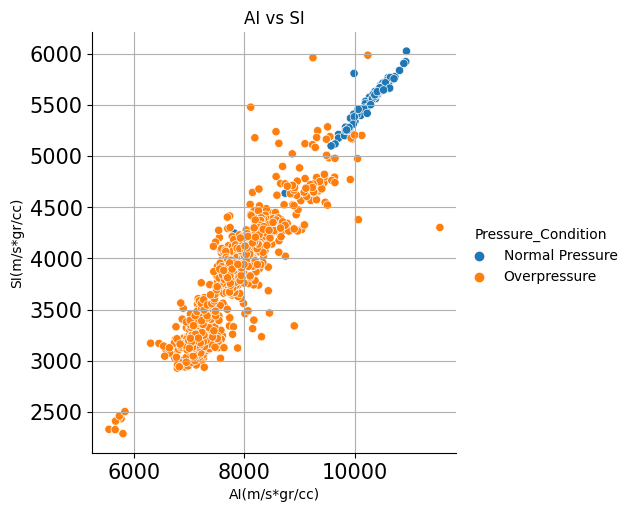

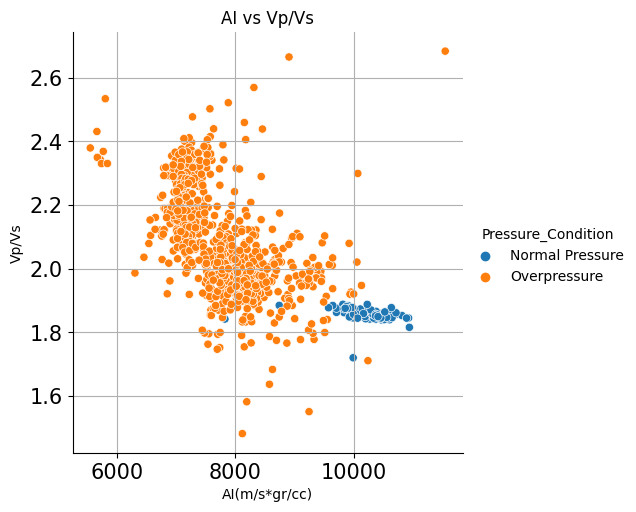

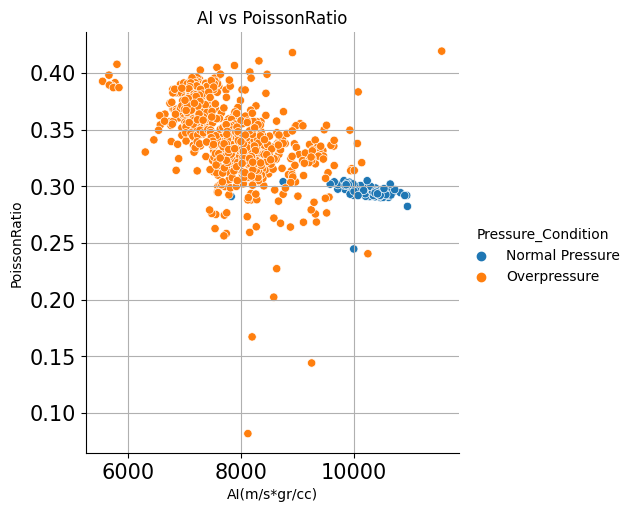

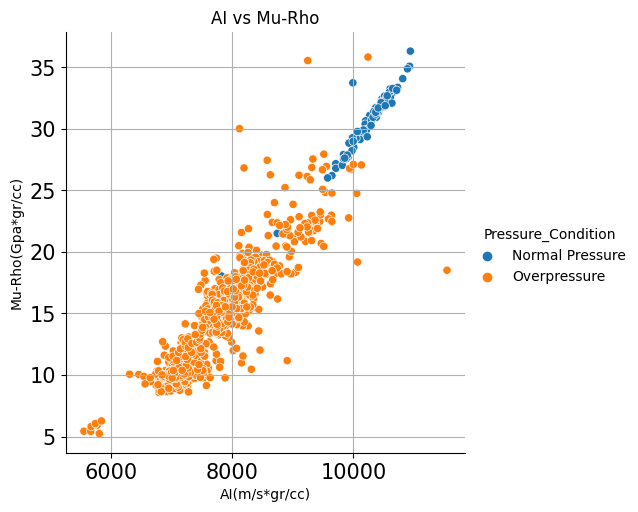

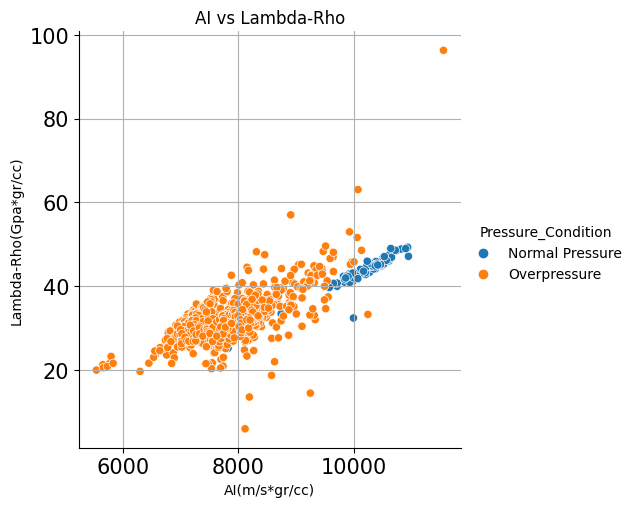

In [72]:

char7=sns.relplot(data=logplot,x="AI", y="SI", hue="Pressure_Condition").set(title='AI vs SI', xlabel='AI(m/s*gr/cc)', ylabel='SI(m/s*gr/cc)')
plt.grid()
char8=sns.relplot(data=logplot,x="AI", y="Vp/Vs", hue="Pressure_Condition").set(title='AI vs Vp/Vs', xlabel='AI(m/s*gr/cc)', ylabel='Vp/Vs')
plt.grid()
char9=sns.relplot(data=logplot,x="AI", y="PoissonRatio", hue="Pressure_Condition").set(title='AI vs PoissonRatio', xlabel='AI(m/s*gr/cc)', ylabel='PoissonRatio')
plt.grid()
char10=sns.relplot(data=logplot,x="AI", y="MR", hue="Pressure_Condition").set(title='AI vs Mu-Rho', xlabel='AI(m/s*gr/cc)', ylabel='Mu-Rho(Gpa*gr/cc)')
plt.grid()
char11=sns.relplot(data=logplot,x="AI", y="LR", hue="Pressure_Condition").set(title='AI vs Lambda-Rho', xlabel='AI(m/s*gr/cc)', ylabel='Lambda-Rho(Gpa*gr/cc)')
plt.grid()

In [73]:
logdrill=lasio.read(r'F:/Poseidon/Data Poseidon/Well/3. Well Drill/Poseidon North-1 Drilling Data.las', engine='normal')
logdrill=logdrill.df().reset_index()
logdrill.head()

,UNKNOWN,ROP OFFLINE,SURFACE TORQUE,WEIGHT ON BIT DRILLER,MUD WEIGHT IN,MUD WEIGHT OUT,TEMPERATURE IN,TEMPERATURE OUT,D-EXPONENT,TOTAL RPM [SURFACE + DHM],STAND PIPE PRESSURE,PUMP FLOW,TOTALROTARYTIME,BIT TIME,BIT RUN,TOTALCUMREVONBOTTOM,SUM ALL PITS,ECD
0,508.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,508.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,509.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,509.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,510.0,76.37,0.0,0.0,8.6,0.25,31.3,35.0,NaN,44.0,392.0,407.0,2.39,0.01,0.57,43.0,2324.23,8.6


In [74]:
logCL=lasio.read(r'F:\Poseidon\Python Poseidon\Pressure Data\1.Casing & LOT\Poseidon North 1_logs.las')
logCL=logCL.df().reset_index()
logCL.head()
logcalcase=logCL[logCL['CALIPERCASING'] !=0]
logcalcase=logcalcase.dropna(subset=['CALIPERCASING'])

In [75]:
Caliper_Casing = {'DEPTH': [567.9,2452.5,2452.5,2452.5,3814.2,3814.2,5287.2],
                'CALIPERCASING' : [762,762,340,340,340,244,244]}

logcc = pd.DataFrame(Caliper_Casing)

logcc.head()

,DEPTH,CALIPERCASING
0,567.9,762
1,2452.5,762
2,2452.5,340
3,2452.5,340
4,3814.2,340


In [76]:
logshale = log[(log.DEPTH >= 3000) & (log.DEPTH <= max(log.DEPTH)) & (log['GR'] >75) ]

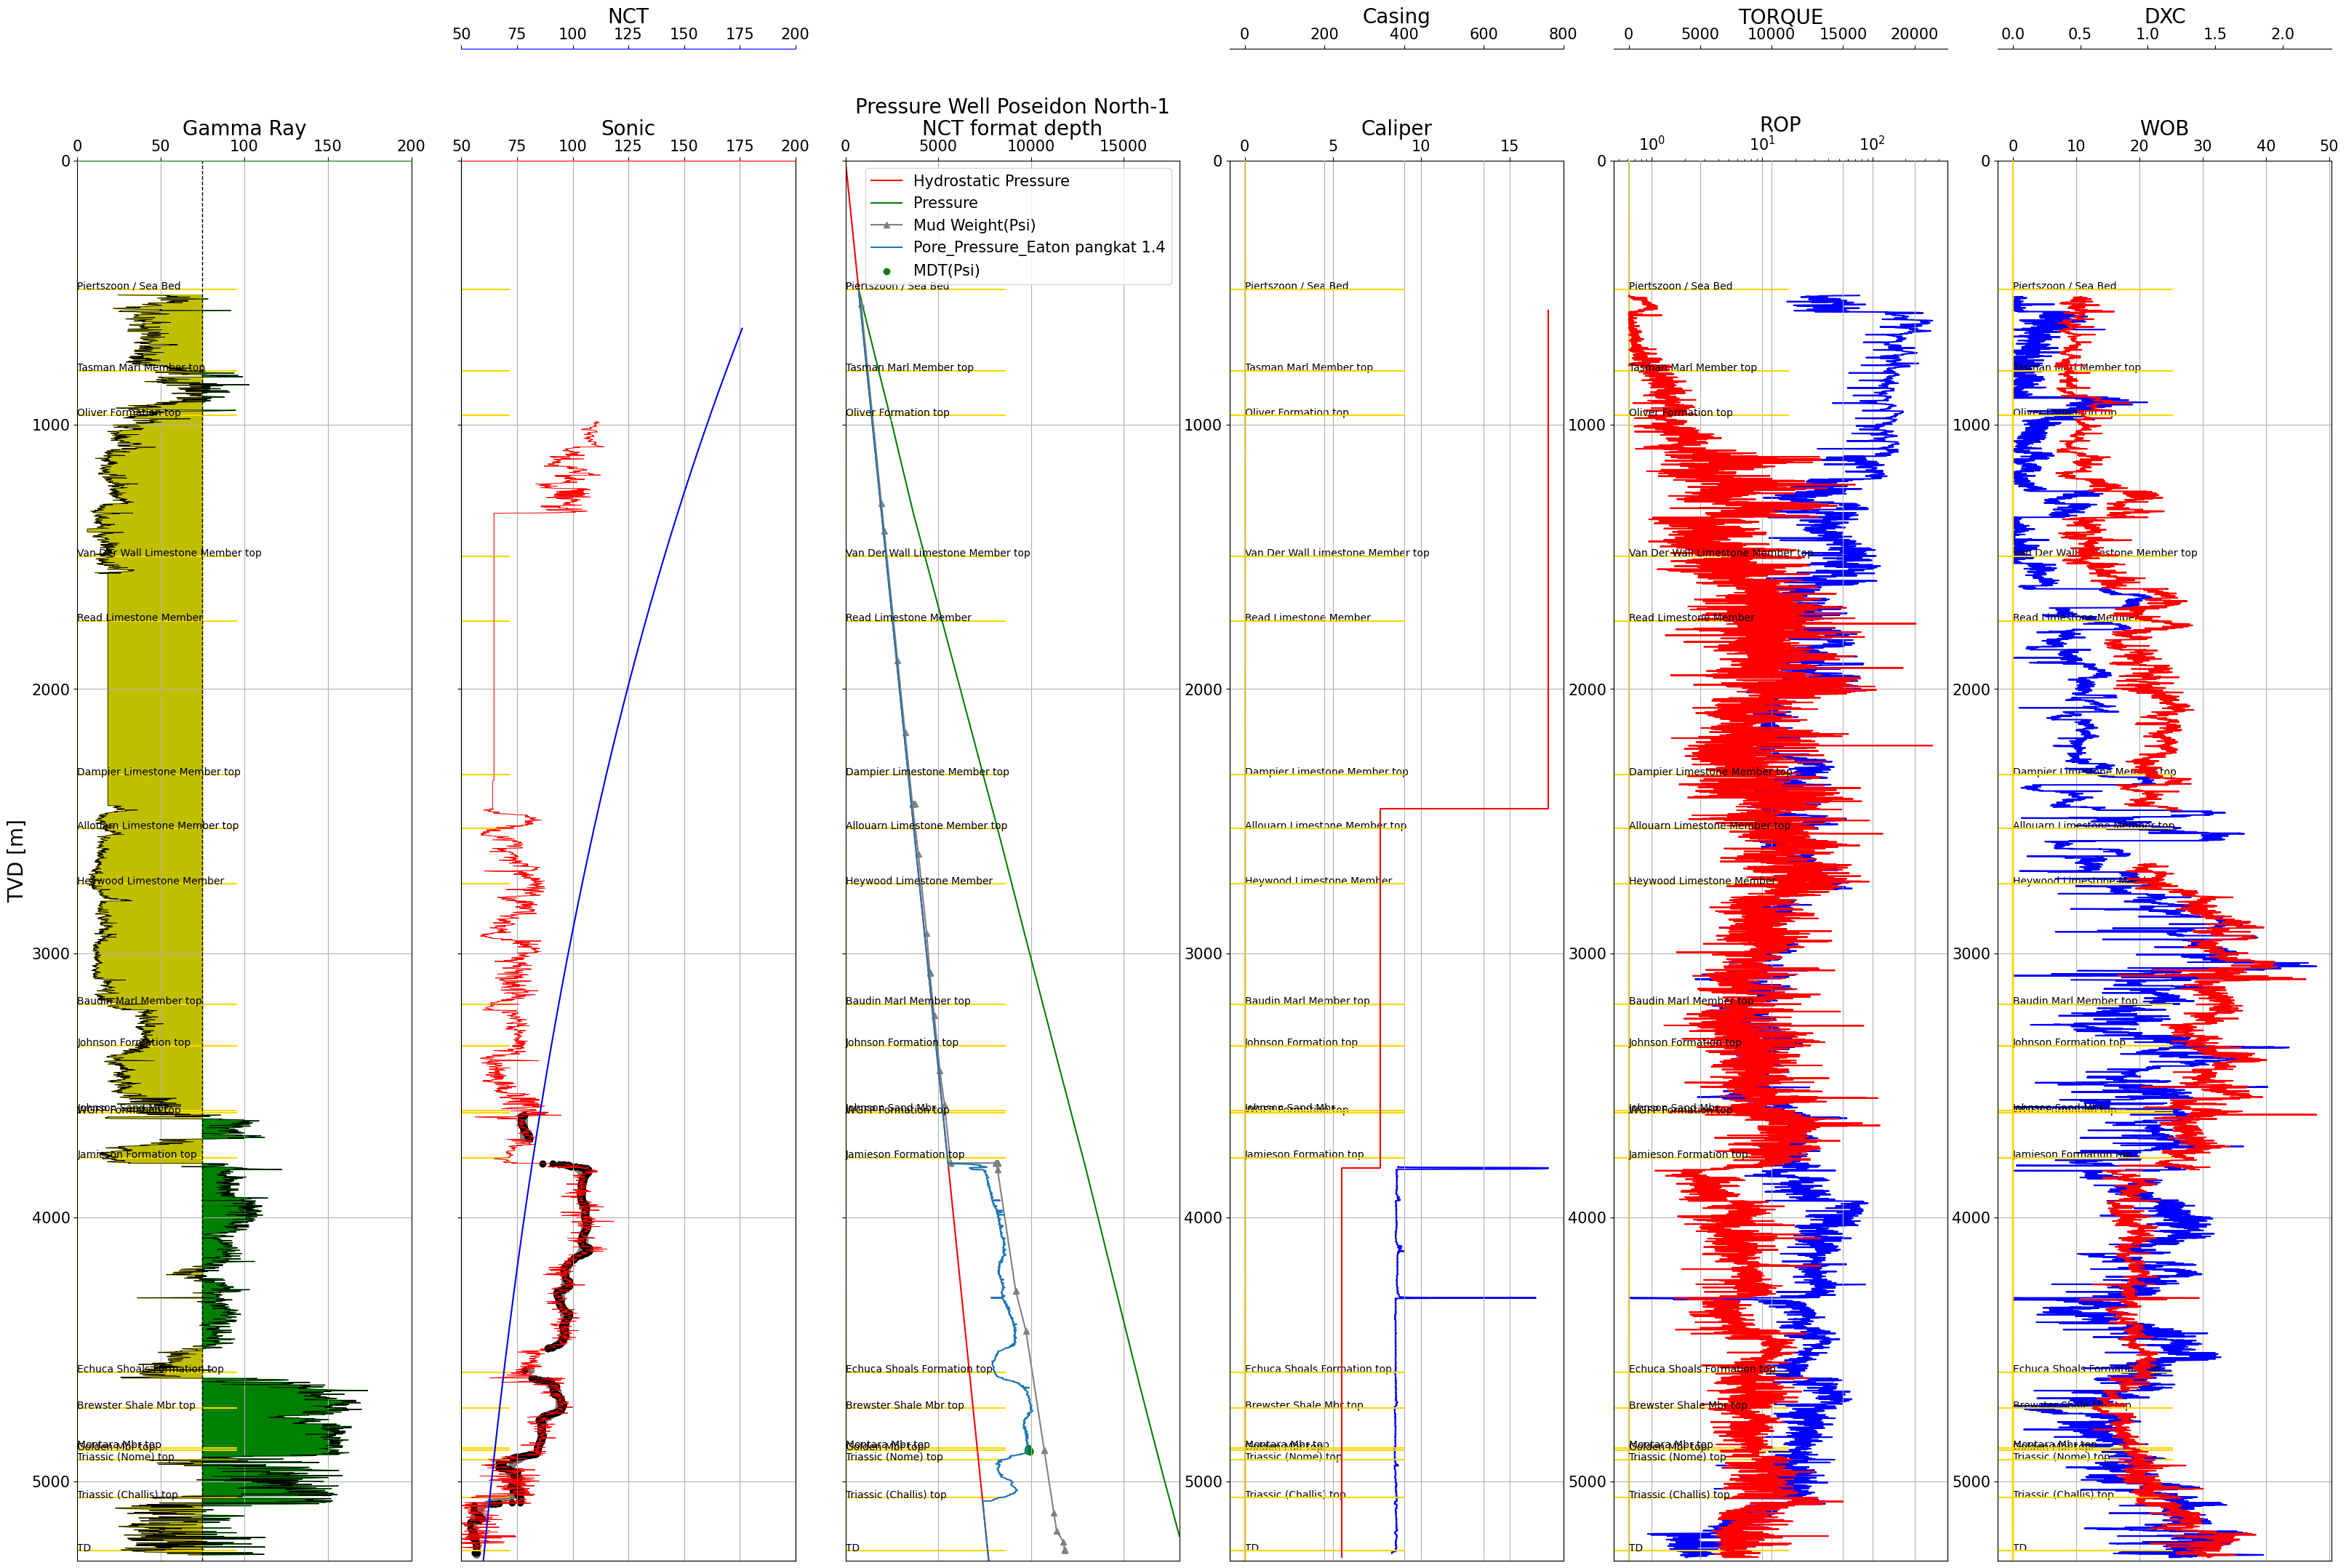

In [77]:
fig, axes = plt.subplots(figsize=(40,25))

curve_names = ['Gamma Ray','Sonic', 'NCT','NCT format depth','Caliper','Casing','ROP','TORQUE','WOB','DXC']


#Set up the plot axes
ax1 = plt.subplot2grid((1,6), (0,0), rowspan=1, colspan = 1) 
ax2 = plt.subplot2grid((1,6), (0,1), rowspan=1, colspan = 1)
ax3= ax2.twiny()
ax4= plt.subplot2grid((1,6), (0,2), rowspan=1, colspan = 1)
ax5=plt.subplot2grid((1,6), (0,3), rowspan=1, colspan = 1)
ax6=ax5.twiny()
ax7=plt.subplot2grid((1,6), (0,4), rowspan=1, colspan = 1)
ax8=ax7.twiny()
ax9=plt.subplot2grid((1,6), (0,5), rowspan=1, colspan = 1)
ax10=ax9.twiny()

#Set up the individual log tracks / subplots
ax1.plot("GR", "DEPTH", data = log, color = "k", lw = 0.5)
ax1.set_xlim(0, 200) 
ax1.spines['top'].set_edgecolor('green')
Cutoff=75
ax1.fill_betweenx(log['DEPTH'],log['GR'],Cutoff,
                           where=log['GR']>Cutoff,interpolate=True,color='g', label='shales')
ax1.fill_betweenx(log['DEPTH'],log['GR'],Cutoff,
                           where=log['GR']<Cutoff,interpolate=True,color='y', label='sands')
ax1.axvline(Cutoff,color='k',linewidth=1,linestyle='--')
ax1.set_ylabel('TVD [m]',fontsize=20)
ax2.plot("DT:1", "DEPTH", data = log, color = "red", lw = 0.5)
ax2.spines['top'].set_edgecolor('red')
ax2.set_xlim(50,200)
ax3.plot("DT:1","DEPTH",data=log,color='red', lw=0.5)
ax3.scatter("DT_100","DEPTH",data=logshale, c='grey',label='DTc Shale')
ax3.scatter("DT_30","DEPTH",data=logshale, c='black',label='DTc Shale')
ax3.set_xlabel('DT(us/ft)',fontsize='large')
ax3.spines['top'].set_edgecolor('blue')
ax3.set_xlim(50,200)
n_smooth = 150
x_unit_trend=log['DT:1'].rolling(n_smooth).median()
y_unit_trend=(log['DEPTHSHIFT']).rolling(n_smooth).median()
mask = (y_unit_trend>fit_interval[0])&(y_unit_trend<fit_interval[1])
x=[20.60228734, 180.61230556,  2.95000e-04]
pred = np.array([DTc_NCTL(x[0], x[1], z,x[2]) for z in y_unit_trend])
ax3.plot(pred,log.DEPTH,'blue',label='NCT Shale')
ax4.set_title("Pressure Well Poseidon North-1",fontsize=20)
ax4.plot(log['Hydrostatic_Pressure_at_bit2']*(145.038/1e6),log['DEPTH'],linestyle='-', c='r',label='Hydrostatic Pressure')
ax4.plot(log['Lithostatic_Pressure_at_bit']*(145.038/1e6),log['DEPTH'],linestyle='-', c='g',label='Pressure')
ax4.plot(df2['Mud Weight(psi) TVD'],df2['TVDRT (m)']-25,marker='^',color = 'gray',label='Mud Weight(Psi)')
ax4.scatter(mdt['Final Pressure (Psia)'],mdt['Pretest DEPTH TVDMSL']-25,label='MDT(Psi)',color = 'green')
ax4.plot(log['PPFinal'],log.DEPTH,label='Pore_Pressure_Eaton pangkat 1.4')
ax4.set_xlabel('Pressure (Psi)',fontsize=20)
ax4.set_xlim(0,18000)
ax4.legend(loc='upper right',fontsize=15)
ax5.plot(log['CALI'],log.DEPTH,color='blue',label='CALIPER_OPENHOLE')
ax6.plot(logcc['CALIPERCASING'],logcc.DEPTH,color='red',linestyle='-',label='CALIPER_CASING')
ax7.plot(logdrill['ROP OFFLINE'],logdrill.UNKNOWN,color='blue',label='ROP')
ax7.semilogx()
ax8.plot(logdrill['SURFACE TORQUE'],logdrill.UNKNOWN,color='red',linestyle='-',label='RPM')
ax9.plot(logdrill['WEIGHT ON BIT DRILLER'],logdrill.UNKNOWN,color='blue',label='ROP')
ax10.plot(logdrill['D-EXPONENT'],logdrill.UNKNOWN,color='red',linestyle='-',label='RPM')
#Set up the common elements between the subplots
for i, ax in enumerate(fig.axes):
    ax.set_ylim(0, 5300) # Set the depth range
    ax.scatter(toptvdss,abs(top['TVDSS']),marker="+",s=100000,c="gold")
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")
    ax.set_xlabel(curve_names[i],fontsize=20)
    ax.invert_yaxis()
    if i == 2:
        ax.spines["top"].set_position(("axes", 1.08))
    if i == 5 :
        ax.spines["top"].set_position(("axes", 1.08))
    if i == 7 :
        ax.spines["top"].set_position(("axes", 1.08))
    if i == 9 :
        ax.spines["top"].set_position(("axes", 1.08))
    else:
        ax.grid()
        
for i, txt in enumerate(labs):
    ax1.annotate(txt, (toptvdss[i],abs(top['TVDSS'])[i]))
    ax3.annotate(txt, (toptvdss[i],abs(top['TVDSS'])[i]))
    ax4.annotate(txt, (toptvdss[i],abs(top['TVDSS'])[i]))
    ax5.annotate(txt, (toptvdss[i],abs(top['TVDSS'][i])))
    ax8.annotate(txt, (toptvdss[i],abs(top['TVDSS'][i])))
    ax9.annotate(txt, (toptvdss[i],abs(top['TVDSS'][i])))
#Hide tick labels on the y-axis 

for ax in [ax2, ax4]:
    plt.setp(ax.get_yticklabels(), visible = False)


#Reduce the space between each subplot
fig.subplots_adjust(wspace = 0.15)

# Display Well Poseidon North-1 Pore Pressure

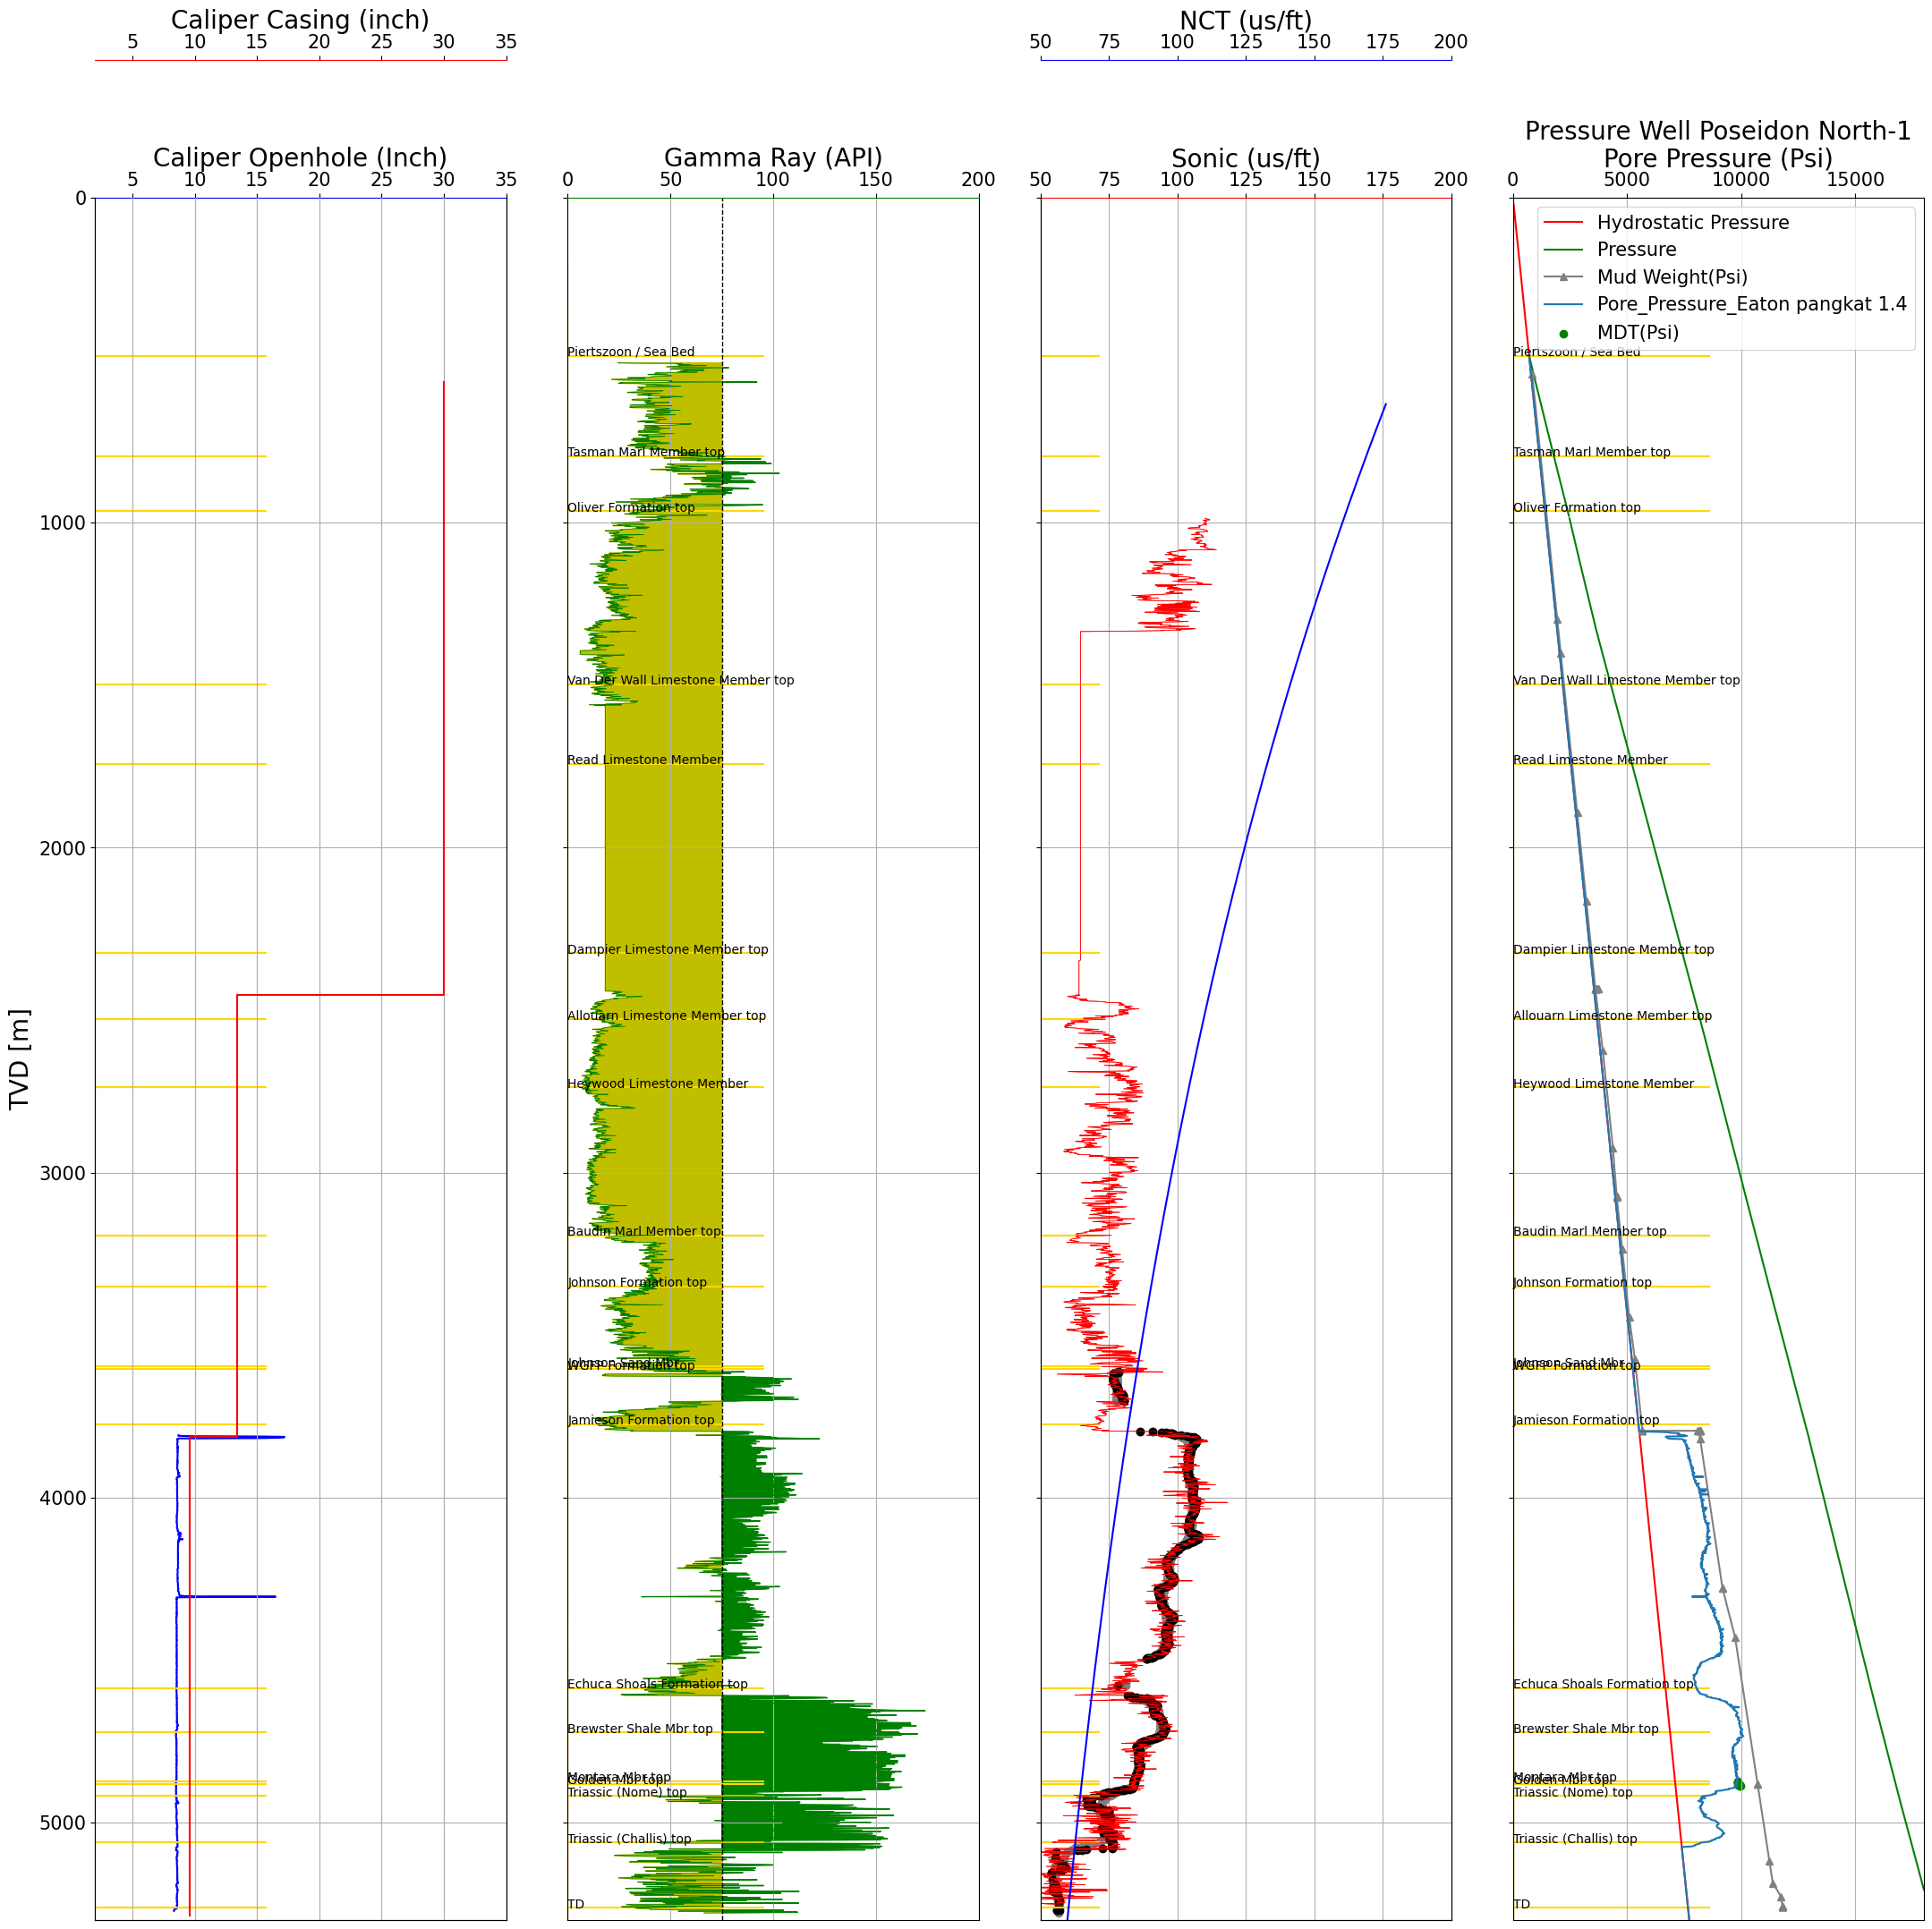

In [78]:
fig, axes = plt.subplots(figsize=(40,25))

curve_names = ['Caliper Openhole (Inch)','Caliper Casing (inch)','Gamma Ray (API)','Sonic (us/ft)', 'NCT (us/ft)','Pore Pressure (Psi)']


#Set up the plot axes
ax1=plt.subplot2grid((1,6), (0,0), rowspan=1, colspan = 1)
ax2=ax1.twiny()
ax3 = plt.subplot2grid((1,6), (0,1), rowspan=1, colspan = 1) 
ax4 = plt.subplot2grid((1,6), (0,2), rowspan=1, colspan = 1)
ax5= ax4.twiny()
ax6= plt.subplot2grid((1,6), (0,3), rowspan=1, colspan = 1)


#Set up the individual log tracks / subplots
# Log Caliper
ax1.plot(log['CALI'],log.DEPTH,color='blue',label='CALIPER_OPENHOLE')
ax1.spines['top'].set_edgecolor('Blue')
ax1.set_ylabel('TVD [m]',fontsize=20)
ax1.set_xlim(2,35)
ax2.plot(logcc['CALIPERCASING']*0.0393700787,logcc.DEPTH,color='red',linestyle='-',label='CALIPER_CASING')
ax2.spines['top'].set_edgecolor('red')
ax2.set_xlim(2,35)

#log Gamma-ray
ax3.plot("GR", "DEPTH", data = log, color = "green", lw = 0.5)
ax3.set_xlim(0, 200) 
ax3.spines['top'].set_edgecolor('green')
Cutoff=75
ax3.fill_betweenx(log['DEPTH'],log['GR'],Cutoff,
                           where=log['GR']>Cutoff,interpolate=True,color='g', label='shales')
ax3.fill_betweenx(log['DEPTH'],log['GR'],Cutoff,
                           where=log['GR']<Cutoff,interpolate=True,color='y', label='sands')
ax3.axvline(Cutoff,color='k',linewidth=1,linestyle='--')


#log Sonic and NCT Sonic
ax4.plot("DT:1", "DEPTH", data = log, color = "red", lw = 0.5)
ax4.spines['top'].set_edgecolor('red')
ax4.set_xlim(50,200)

ax5.plot("DT:1","DEPTH",data=log,color='red', lw=0.5)
ax5.scatter("DT_100","DEPTH",data=logshale, c='grey',label='DTc Shale')
ax5.scatter("DT_30","DEPTH",data=logshale, c='black',label='DTc Shale')
ax5.set_xlabel('DT(us/ft)',fontsize='large')
ax5.spines['top'].set_edgecolor('blue')
ax5.set_xlim(50,200)
n_smooth = 150
x_unit_trend=log['DT:1'].rolling(n_smooth).median()
y_unit_trend=(log['DEPTHSHIFT']).rolling(n_smooth).median()
mask = (y_unit_trend>fit_interval[0])&(y_unit_trend<fit_interval[1])
x=[20.60228734, 180.61230556,  2.95000e-04]
pred = np.array([DTc_NCTL(x[0], x[1], z,x[2]) for z in y_unit_trend])
ax5.plot(pred,log.DEPTH,'blue',label='NCT Shale')

#lResult of Pore pRessure Use Eaton
ax6.set_title("Pressure Well Poseidon North-1",fontsize=20)
ax6.plot(log['Hydrostatic_Pressure_at_bit2']*(145.038/1e6),log['DEPTH'],linestyle='-', c='r',label='Hydrostatic Pressure')
ax6.plot(log['Lithostatic_Pressure_at_bit']*(145.038/1e6),log['DEPTH'],linestyle='-', c='g',label='Pressure')
ax6.plot(df2['Mud Weight(psi) TVD'],df2['TVDRT (m)']-25,marker='^',color = 'gray',label='Mud Weight(Psi)')
ax6.scatter(mdt['Final Pressure (Psia)'],mdt['Pretest DEPTH TVDMSL']-25,label='MDT(Psi)',color = 'green')
ax6.plot(log['PPFinal'],log.DEPTH,label='Pore_Pressure_Eaton pangkat 1.4')
ax6.set_xlabel('Pressure (Psi)',fontsize=20)
ax6.set_xlim(0,18000)
ax6.legend(loc='upper right',fontsize=15)

#Set up the common elements between the subplots
for i, ax in enumerate(fig.axes):
    ax.set_ylim(0, 5300) # Set the depth range
    ax.scatter(toptvdss,abs(top['TVDSS']),marker="+",s=100000,c="gold")
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")
    ax.set_xlabel(curve_names[i],fontsize=20)
    ax.invert_yaxis()
    if i == 1:
        ax.spines["top"].set_position(("axes", 1.08))
    if i == 4 :
        ax.spines["top"].set_position(("axes", 1.08))
    else:
        ax.grid()
        
for i, txt in enumerate(labs):
    ax2.annotate(txt, (toptvdss[i],abs(top['TVDSS'])[i]))
    ax3.annotate(txt, (toptvdss[i],abs(top['TVDSS'])[i]))
    ax4.annotate(txt, (toptvdss[i],abs(top['TVDSS'])[i]))
    ax5.annotate(txt, (toptvdss[i],abs(top['TVDSS'][i])))
    ax6.annotate(txt, (toptvdss[i],abs(top['TVDSS'][i])))

#Hide tick labels on the y-axis 

for ax in [ax2, ax3,ax4,ax5,ax6]:
    plt.setp(ax.get_yticklabels(), visible = False)


#Reduce the space between each subplot
fig.subplots_adjust(wspace = 0.15)

# Blind Test Well

In [99]:
# logBTW1=lasio.read(r'F:\Poseidon\Python Poseidon\Crossplot sensitive of Overpressure\New Data\Blind Test Well\Eaton Pangkat 1.3\Poseidon North 1_logs.las')
# logBTW1=logBTW1.df().reset_index()
# logBTW1.head()
# logBTW2=lasio.read(r'F:\Poseidon\Python Poseidon\Crossplot sensitive of Overpressure\New Data\Blind Test Well\Pangkat Kriging tanpa koreksi dari sumur poseidon 1 dan proteus 1st2\Poseidon North 1_logs.las')
# logBTW2=logBTW2.df().reset_index()
# logBTW2.head()
# logBTW3=lasio.read(r'F:\Poseidon\Python Poseidon\Crossplot sensitive of Overpressure\New Data\Blind Test Well\Pangkat Kriging\Poseidon North 1_logs.las')
# logBTW3=logBTW3.df().reset_index()
# logBTW3.head()
# logBTW4=lasio.read(r'F:\Poseidon\Python Poseidon\Crossplot sensitive of Overpressure\New Data\Blind Test Well\PP Eaton Newest\Poseidon North 1_logs.las')
# logBTW4=logBTW4.df().reset_index()
# logBTW4.head()
logBTW5=lasio.read(r'F:\Poseidon\Python Poseidon\Crossplot sensitive of Overpressure\New Data\Blind Test Well\PP Eaton Final\Poseidon North 1_logs.las')
logBTW5=logBTW5.df().reset_index()
logBTW5.head()

,DEPTH,UNKNOWN
0,22.0,5.6941
1,23.0,5.6941
2,24.0,5.6941
3,25.0,5.6941
4,26.0,5.7075


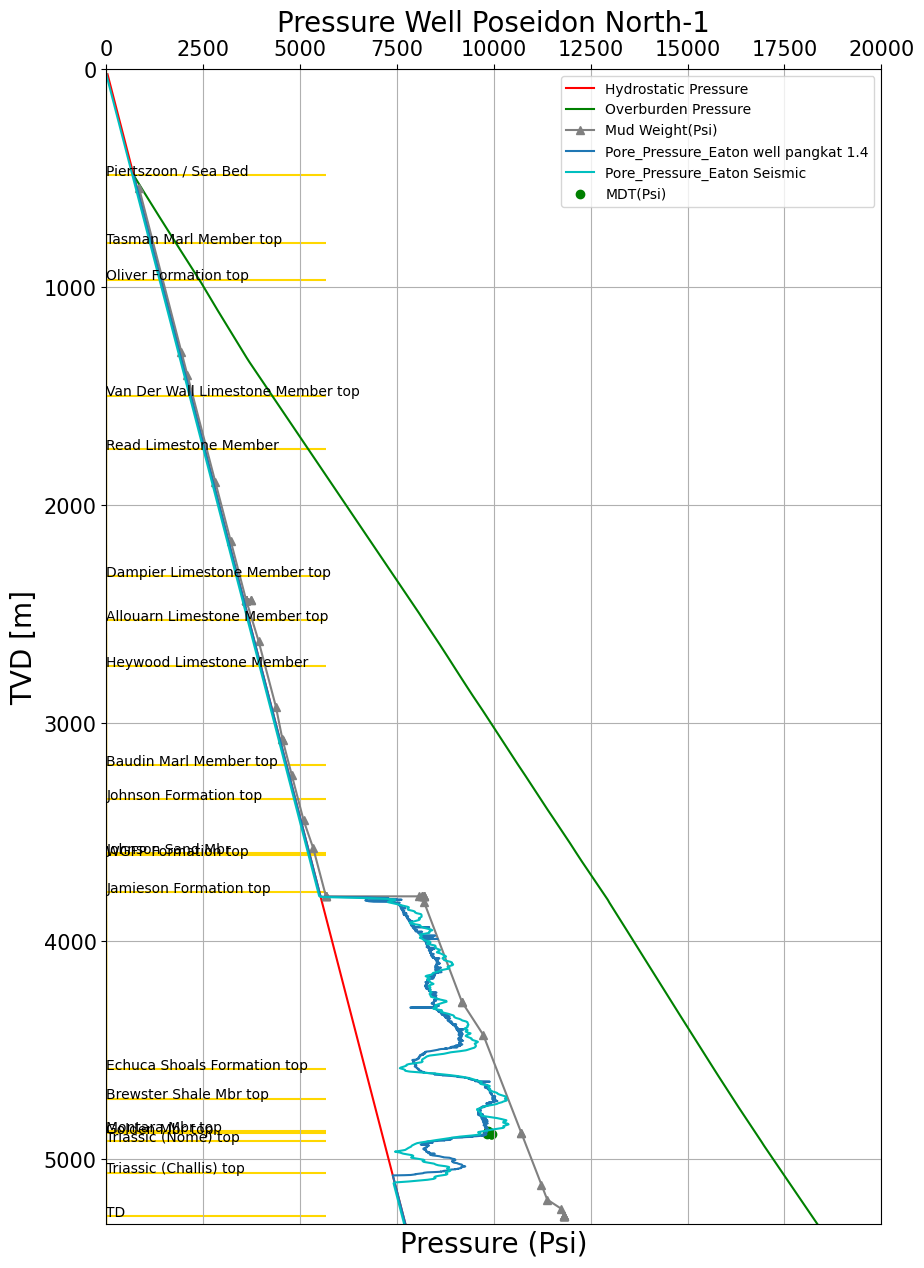

In [100]:
fig,ax=plt.subplots(figsize=(10,15))
ax.set_title("Pressure Well Poseidon North-1",fontsize=20)
ax.plot(log['Hydrostatic_Pressure_at_bit2']*(145.038/1e6),log['DEPTH'],linestyle='-', c='r',label='Hydrostatic Pressure')
ax.plot(log['Lithostatic_Pressure_at_bit']*(145.038/1e6),log['DEPTH'],linestyle='-', c='g',label='Overburden Pressure')
ax.plot(df2['Mud Weight(psi) TVD'],df2['TVDRT (m)']-25,marker='^',color = 'gray',label='Mud Weight(Psi)')
ax.scatter(mdt['Final Pressure (Psia)'],mdt['Pretest DEPTH TVDMSL']-25,label='MDT(Psi)',color = 'green')
ax.plot(log['PPFinal'],log.DEPTH,label='Pore_Pressure_Eaton well pangkat 1.4')
# ax.plot(logBTW1.UNKNOWN,logBTW1.DEPTH,label='Pore_Pressure_Eaton Seismic Data pangkat Skenario 1 ',color='m')
# ax.plot(logBTW2.UNKNOWN,logBTW2.DEPTH,label='Pore_Pressure_Eaton Seismic Data Pangkat Skenario 2 ',color='c')
# ax.plot(logBTW3.UNKNOWN,logBTW3.DEPTH,label='Pore_Pressure_Eaton Seismic Data pangkat skenario 3 ',color='y')
ax.plot(logBTW5.UNKNOWN,logBTW5.DEPTH,label='Pore_Pressure_Eaton Seismic  ',color='c')
ax.set_xlabel('Pressure (Psi)',fontsize=20)
ax.set_ylabel('TVD [m]',fontsize=20)
ax.set_xlim(0,20000)
for i, ax in enumerate(fig.axes):
    ax.set_ylim(0, 5300) # Set the depth range
    ax.scatter(toptvdss,abs(top['TVDSS']),marker="+",s=100000,c="gold")
    ax.xaxis.set_ticks_position("top")
for i, txt in enumerate(labs):
    ax.annotate(txt, (toptvdss[i],abs(top['TVDSS'])[i]))

ax.grid()
ax.legend()
ax.invert_yaxis()

# Export Data Well to LAS

In [101]:
log['Hidrostatik_psi']=log['Hydrostatic_Pressure_at_bit2']*(145.038/1e6)
log['Overburden_psi']=log['Lithostatic_Pressure_at_bit']*(145.038/1e6)

In [102]:
log.loc[(log['DEPTH'] > 0), 'Powers Of Number'] = 1.4
data=log[['DEPTH','DTc_NCT','Hidrostatik_psi','Overburden_psi','PPFinal','PPGFinal','Powers Of Number']]


In [103]:
las_file = lasio.LASFile()
las_file.header

{'Version': [HeaderItem(mnemonic="VERS", unit="", value="2.0", descr="CWLS log ASCII Standa"),
  HeaderItem(mnemonic="WRAP", unit="", value="NO", descr="One line per depth ste"),
  HeaderItem(mnemonic="DLM", unit="", value="SPACE", descr="Column Data Section ")],
 'Well': [HeaderItem(mnemonic="STRT", unit="m", value="nan", descr="START DEPTH"),
  HeaderItem(mnemonic="STOP", unit="m", value="nan", descr="STOP DEPTH"),
  HeaderItem(mnemonic="STEP", unit="m", value="nan", descr="STEP"),
  HeaderItem(mnemonic="NULL", unit="", value="-9999.25", descr="NULL VALUE"),
  HeaderItem(mnemonic="COMP", unit="", value="", descr="COMPANY"),
  HeaderItem(mnemonic="WELL", unit="", value="", descr="WELL"),
  HeaderItem(mnemonic="FLD", unit="", value="", descr="FIELD"),
  HeaderItem(mnemonic="LOC", unit="", value="", descr="LOCATION"),
  HeaderItem(mnemonic="PROV", unit="", value="", descr="PROVINCE"),
  HeaderItem(mnemonic="CNTY", unit="", value="", descr="COUNTY"),
  HeaderItem(mnemonic="STAT", unit=""

In [104]:
well_name = 'Poseidon North-1 Well'
field_name = 'Poseidon Field'
country = 'Australia'

In [105]:
las_file.well['WELL'] = lasio.HeaderItem('WELL', value=well_name)
las_file.well['FLD'] = lasio.HeaderItem('FLD', value=field_name)
las_file.well['CTRY'] = lasio.HeaderItem('CTRY', value=country)
las_file.well['STRT'] = lasio.HeaderItem('STRT', value=min(log.DEPTH))
las_file.well['STOP'] = lasio.HeaderItem('STOP', value=max(log.DEPTH))

In [106]:
las_file.header

{'Version': [HeaderItem(mnemonic="VERS", unit="", value="2.0", descr="CWLS log ASCII Standa"),
  HeaderItem(mnemonic="WRAP", unit="", value="NO", descr="One line per depth ste"),
  HeaderItem(mnemonic="DLM", unit="", value="SPACE", descr="Column Data Section ")],
 'Well': [HeaderItem(mnemonic="STRT", unit="", value="22.0", descr=""),
  HeaderItem(mnemonic="STOP", unit="", value="5523.0", descr=""),
  HeaderItem(mnemonic="STEP", unit="m", value="nan", descr="STEP"),
  HeaderItem(mnemonic="NULL", unit="", value="-9999.25", descr="NULL VALUE"),
  HeaderItem(mnemonic="COMP", unit="", value="", descr="COMPANY"),
  HeaderItem(mnemonic="WELL", unit="", value="Poseidon North-1 Well", descr=""),
  HeaderItem(mnemonic="FLD", unit="", value="Poseidon Field", descr=""),
  HeaderItem(mnemonic="LOC", unit="", value="", descr="LOCATION"),
  HeaderItem(mnemonic="PROV", unit="", value="", descr="PROVINCE"),
  HeaderItem(mnemonic="CNTY", unit="", value="", descr="COUNTY"),
  HeaderItem(mnemonic="STAT", 

In [107]:
units = ['m',
 'us/ft',
 'psi',
 'psi',
 'psi',
 'lbs/gal',
 'UNKNOWN'
 ]

In [108]:
# for col, unit in zip(data.columns, units):
#     if col != 'DEPTH':
#         las_file.append_curve(col, data[col], unit=unit)
for col, unit in zip(data.columns, units):
        las_file.append_curve(col, data[col], unit=unit)

In [109]:
# las_file.write(r'F:/Poseidon/Data Poseidon/Well/4. Well Pore Pressure Parameter/Poseidon North-1.las')

# las Drill data

ax9.plot(logdrill['WEIGHT ON BIT DRILLER'],logdrill.UNKNOWN,color='blue',label='ROP')
ax10.plot(logdrill['D-EXPONENT'],logdrill.UNKNOWN,color='red',linestyle='-',label='RPM')

In [110]:
logdrill['DEPTH']=logdrill.UNKNOWN

In [111]:
data=logdrill[['DEPTH','WEIGHT ON BIT DRILLER','D-EXPONENT']]

In [112]:
las_file = lasio.LASFile()
las_file.header

{'Version': [HeaderItem(mnemonic="VERS", unit="", value="2.0", descr="CWLS log ASCII Standa"),
  HeaderItem(mnemonic="WRAP", unit="", value="NO", descr="One line per depth ste"),
  HeaderItem(mnemonic="DLM", unit="", value="SPACE", descr="Column Data Section ")],
 'Well': [HeaderItem(mnemonic="STRT", unit="m", value="nan", descr="START DEPTH"),
  HeaderItem(mnemonic="STOP", unit="m", value="nan", descr="STOP DEPTH"),
  HeaderItem(mnemonic="STEP", unit="m", value="nan", descr="STEP"),
  HeaderItem(mnemonic="NULL", unit="", value="-9999.25", descr="NULL VALUE"),
  HeaderItem(mnemonic="COMP", unit="", value="", descr="COMPANY"),
  HeaderItem(mnemonic="WELL", unit="", value="", descr="WELL"),
  HeaderItem(mnemonic="FLD", unit="", value="", descr="FIELD"),
  HeaderItem(mnemonic="LOC", unit="", value="", descr="LOCATION"),
  HeaderItem(mnemonic="PROV", unit="", value="", descr="PROVINCE"),
  HeaderItem(mnemonic="CNTY", unit="", value="", descr="COUNTY"),
  HeaderItem(mnemonic="STAT", unit=""

In [113]:
well_name = 'Poseidon North-1 Well'
field_name = 'Poseidon Field'
country = 'Australia'

In [114]:
las_file.well['WELL'] = lasio.HeaderItem('WELL', value=well_name)
las_file.well['FLD'] = lasio.HeaderItem('FLD', value=field_name)
las_file.well['CTRY'] = lasio.HeaderItem('CTRY', value=country)
las_file.well['STRT'] = lasio.HeaderItem('STRT', value=min(log.DEPTH))
las_file.well['STOP'] = lasio.HeaderItem('STOP', value=max(log.DEPTH))

In [115]:
las_file.header

{'Version': [HeaderItem(mnemonic="VERS", unit="", value="2.0", descr="CWLS log ASCII Standa"),
  HeaderItem(mnemonic="WRAP", unit="", value="NO", descr="One line per depth ste"),
  HeaderItem(mnemonic="DLM", unit="", value="SPACE", descr="Column Data Section ")],
 'Well': [HeaderItem(mnemonic="STRT", unit="", value="22.0", descr=""),
  HeaderItem(mnemonic="STOP", unit="", value="5523.0", descr=""),
  HeaderItem(mnemonic="STEP", unit="m", value="nan", descr="STEP"),
  HeaderItem(mnemonic="NULL", unit="", value="-9999.25", descr="NULL VALUE"),
  HeaderItem(mnemonic="COMP", unit="", value="", descr="COMPANY"),
  HeaderItem(mnemonic="WELL", unit="", value="Poseidon North-1 Well", descr=""),
  HeaderItem(mnemonic="FLD", unit="", value="Poseidon Field", descr=""),
  HeaderItem(mnemonic="LOC", unit="", value="", descr="LOCATION"),
  HeaderItem(mnemonic="PROV", unit="", value="", descr="PROVINCE"),
  HeaderItem(mnemonic="CNTY", unit="", value="", descr="COUNTY"),
  HeaderItem(mnemonic="STAT", 

In [116]:
units = ['m',
 't',
 'euc',
]

In [117]:
for col, unit in zip(data.columns, units):
        las_file.append_curve(col, data[col], unit=unit)

In [118]:
# las_file.write(r'E:\New folder\3. Well Drill\Drill New\Poseidon North-1.las')